In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import math
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import statsmodels.api as sm
from flownetwork import flownetwork
import pickle

%matplotlib inline
plt.style.use('ggplot')

from matplotlib.pyplot import cm 

# refreshing results
def flushPrint(variable):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % variable)
    sys.stdout.flush()

def powerRankPlot(data, col,marker):
    t = np.array(sorted(data,key=lambda x:-x))*100
    t = t[:10000]
    r = np.array(range(len(t))) +1
    x = np.log(r)
    y = np.log(t +10**(-10))
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant, beta = res.params
    r2 = res.rsquared
    txt = '$\\alpha = $' + str(np.round(beta,2)) + ', ' + '$R^2 = $' + str(np.round(r2, 2))
    plt.plot(r,t, marker = marker, linestyle = '' , color=col, markersize=5 , label = txt)
    plt.plot(r, np.exp(constant+x*beta), 'grey')
    plt.xscale('log'); 
    plt.yscale('log')
    # plt.xlabel(r'$Rank$', fontsize = 20)
    # plt.ylabel(r'$Value$', fontsize = 20)
    plt.legend(loc = 0, frameon = False)
    plt.ylim(0, 100)

# Data Preparation

In [3]:
df = pd.read_csv('./gprs_q_20180605_pandas.txt')

In [60]:
df = df[df.website != 'none'].drop_duplicates()
df = df.dropna(axis = 0)
len(df)

20334784

In [61]:
df.to_csv('./gprs_q_20180605_pandas_clean.txt', index=False)

In [11]:
df = pd.read_csv('./gprs_q_20180605_pandas_clean.txt')

In [12]:
uids = df.user.unique()
total_uv = len(uids)
total_pv = len(df)
print(total_uv, total_pv)

89175 20334784


In [63]:
W = defaultdict(lambda:0)
for k, u in enumerate(df.user.unique()):
    if k % 100 == 0:
        flushPrint(float(k)/total_uv)
    p =  df[df['user']==u]['website'] 
    plist = zip(p[:-1],p[1:])
    plist = ['\t'.join(sorted([i[0], i[1]])) for i in plist]
    plist = list(set(plist))
    plist = [i.split('\t') for i in plist]
    for i,j in plist:
        if i!=j:
            W[(i,j)] +=1

0.9667968755555556465

In [71]:
df_webster = pd.DataFrame(list(W.items()), columns =['edge', 'weight'])
df_webster.to_csv('./df_webster.csv', index=False)

## start from here

In [4]:
df_pvuv = pd.read_csv('./web_pv_uv.txt')
total_uv = 89175
total_pv = df_pvuv['pv'].sum()
print(len(df_pvuv))

pvuv_dict = {}
for i in df_pvuv.index:
    pvuv_dict[df_pvuv.web[i] ] = (df_pvuv.pv[i]/float(total_pv), df_pvuv.uv[i]/float(total_uv))

25750


In [5]:
df_webster = pd.read_csv('./df_webster.csv')

In [6]:
df_webster.head(10)

,edge,weight
0,"('duapp.com', 'umeng.com')",586
1,"('qpic.cn', 'weduty.com')",3
2,"('qq.com', 'weduty.com')",5
3,"('qpic.cn', 'qq.com')",34248
4,"('duapp.com', 'umeng.co')",136
5,"('duapp.com', 'qq.com')",4854
6,"('htcsrv.cn', 'qq.com')",321
7,"('360.cn', 'weduty.com')",1
8,"('umeng.com', 'weibo.cn')",567
9,"('duapp.com', 'qpic.cn')",1886


In [20]:
# original overlap network
g0 = nx.Graph()
for i in df_webster.index:
    source, target = eval(df_webster.edge[i])
    g0.add_edge(source, target)
print(nx.info(gw0))

# degree distribution of original network

# pv, uv = np.array(list(pvuv_dict.values())).T
# uv_ratio = [u/float(total_uv) for u in uv]
# degree_score0 = nx.degree_centrality(g0)
# fig = plt.figure(figsize=(6,5),facecolor='white')
# powerRankPlot(degree_score0.values(), 'red', 'o')

Name: 
Type: Graph
Number of nodes: 25643
Number of edges: 370928
Average degree:  28.9302


In [26]:
with open('degree_score_gw_list_population.pkl', 'rb') as input:
    degree_score_gw_list = pickle.load(input)
    
with open('degree_score_gs_list_population.pkl', 'rb') as input:
    degree_score_gs_list = pickle.load(input)
    
with open('degree_score_gw0.pkl', 'rb') as input:
    degree_score_gw0 = pickle.load(input)
    
with open('degree_score_gs0.pkl', 'rb') as input:
    degree_score_gs0 = pickle.load(input)

In [18]:
thresholds = [0.03, 0.0001]
dfaici = pd.read_csv('dfaici.csv')
sortedci = dfaici.sort_values(by='ci', ascending=False)['ci'].values

# 2018.6.6
## webster approach

In [22]:
# webster duplication network
gw0 = nx.Graph()
for i in df_webster.index:
    source, target = eval(df_webster.edge[i])
    try:
        source_uv_rate = pvuv_dict[source][1]
        target_uv_rate = pvuv_dict[target][1]
        weight = df_webster.weight[i]/float(total_uv)
        if weight >= source_uv_rate*target_uv_rate:
            gw0.add_edge(source, target)
    except:
        pass
print(nx.info(gw0))

Name: 
Type: Graph
Number of nodes: 25634
Number of edges: 271096
Average degree:  21.1513


In [24]:
degree_score_gw0 = nx.degree_centrality(gw0)
with open('degree_score_gw0.pkl', 'wb') as output:
    pickle.dump(degree_score_gw0, output, pickle.HIGHEST_PROTOCOL)

In [57]:
# webster network after cutting nodes whose reach is < 0.03
# the network need to be rebuilt so that the edges can be re-filtered

popnodes = []
for node in gw0.nodes():
    if pvuv_dict[node][1] >= 0.03:
        popnodes.append(node)
print(len(popnodes))

gw = nx.Graph()
for i in df_webster.index:
    source, target = eval(df_webster.edge[i])
    if source in popnodes:
        if target in popnodes:
            source_uv_rate = pvuv_dict[source][1]
            target_uv_rate = pvuv_dict[target][1]
            weight = df_webster.weight[i]/float(total_uv)
            if source == '10086.cn':
                if weight >= source_uv_rate*target_uv_rate:
                    print(source, target, source_uv_rate*target_uv_rate, weight)
            if weight >= source_uv_rate*target_uv_rate:
                gw.add_edge(source, target)
print(nx.info(gw))

60


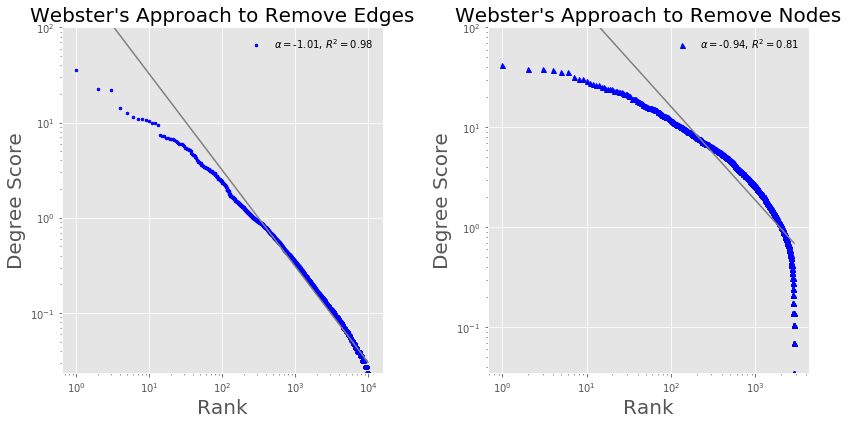

In [159]:
degree_score_gw0 = nx.degree_centrality(gw0)
degree_score_gw = nx.degree_centrality(gw)

fig = plt.figure(figsize=(12,6),facecolor='white')
ax = fig.add_subplot(1, 2, 1)
# powerRankPlot(uv_ratio, 'yellow', 's')
powerRankPlot(degree_score_gw0.values(), 'b', '.')
ax.set_title('Webster\'s Approach to Remove Edges', fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)
ax = fig.add_subplot(1, 2, 2)
powerRankPlot(degree_score_gw.values(), 'blue', '^')
ax.set_title('Webster\'s Approach to Remove Nodes', fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)

plt.tight_layout()

In [427]:
# use a list of thresholds to filter nodes

# webster network after cutting nodes whose reach is < 0.03
# the network need to be rebuilt so that the edges can be re-filtered

thresholds = [0.03, 0.0001]

degree_score_gw_list = []

for tindex in range(len(thresholds)):
    popnodes = []
    for node in gw0.nodes():
        if pvuv_dict[node][1] >= thresholds[tindex]:
            popnodes.append(node)
    print(thresholds[tindex], len(popnodes))

    gw = nx.Graph()
    for i in df_webster.index:
        source, target = eval(df_webster.edge[i])
        if source in popnodes:
            if target in popnodes:
                source_uv_rate = pvuv_dict[source][1]
                target_uv_rate = pvuv_dict[target][1]
                weight = df_webster.weight[i]/float(total_uv)
                
                # debug
                # if source == '10086.cn':
                #    if weight >= source_uv_rate*target_uv_rate:
                #        print(source, target, source_uv_rate*target_uv_rate, weight)
                
                if weight >= source_uv_rate*target_uv_rate:
                    gw.add_edge(source, target)
    print(thresholds[tindex], nx.info(gw))

    degree_score_gw = nx.degree_centrality(gw)
    degree_score_gw_list.append(degree_score_gw)

0.03 60
0.03 Name: 
Type: Graph
Number of nodes: 58
Number of edges: 239
Average degree:   8.2414
0.0001 2871
0.0001 Name: 
Type: Graph
Number of nodes: 2869
Number of edges: 123448
Average degree:  86.0565


In [433]:
with open('degree_score_gw_list_population.pkl', 'wb') as output:
    pickle.dump(degree_score_gw_list, output, pickle.HIGHEST_PROTOCOL)

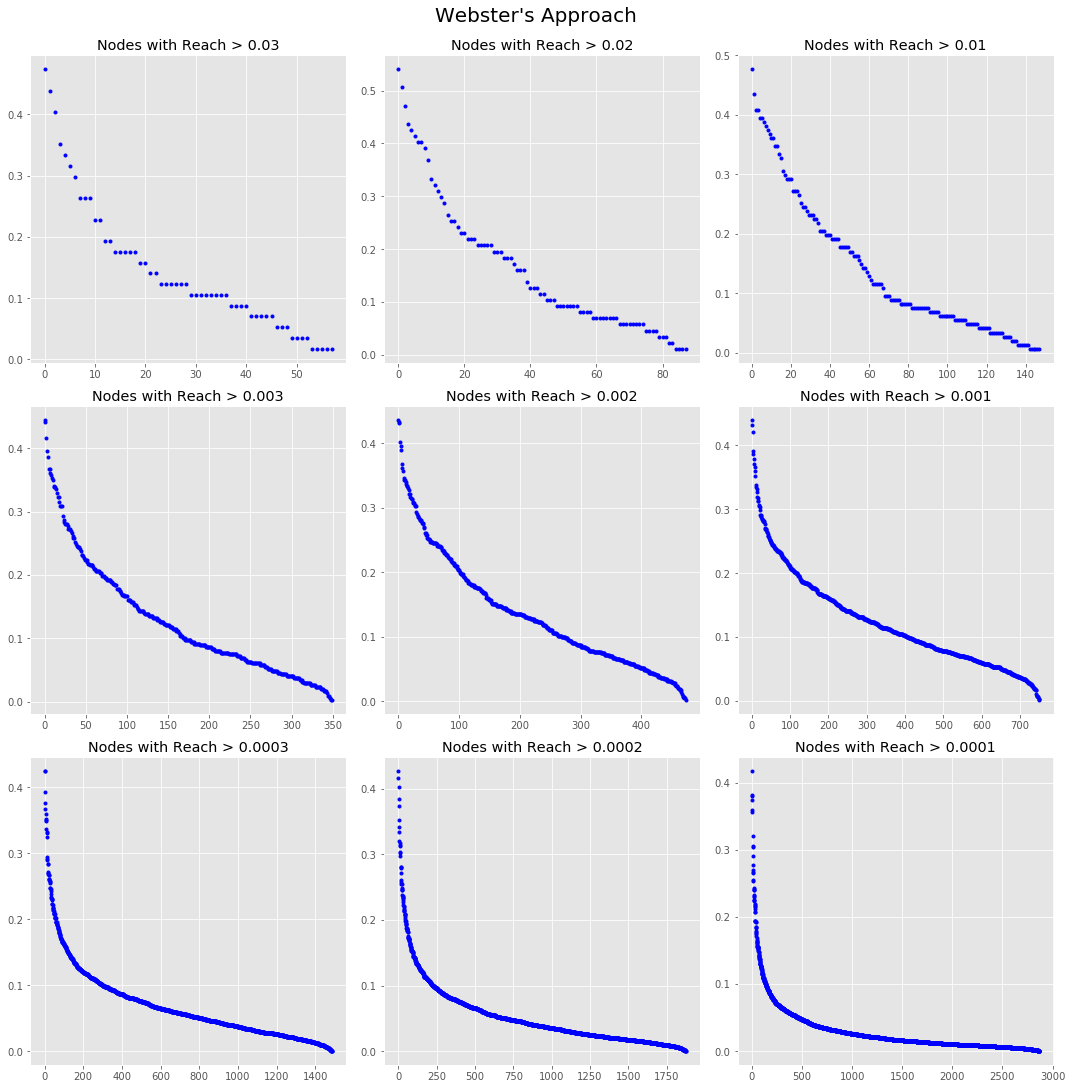

In [59]:
fig = plt.figure(figsize=(15,5 * len(thresholds)),facecolor='white')
fig.suptitle("Webster\'s Approach", fontsize=20)
for tindex in range(len(thresholds)):
    ax = fig.add_subplot(len(thresholds), 3, tindex+1)
    degree_score_gw = degree_score_gw_list[tindex]
    ax.plot(range(len(degree_score_gw)), sorted(degree_score_gw.values(), reverse=True), '.b')
    ax.set_title('Nodes with Reach > ' + str(thresholds[tindex]))
    
fig.tight_layout()
fig.subplots_adjust(top=0.965)

## sandra approach

In [23]:
# sandra network
gs0 = nx.Graph()
for i in df_webster.index:
    source, target = eval(df_webster.edge[i])
    try:
        source_uv = pvuv_dict[source][1] * total_uv
        target_uv = pvuv_dict[target][1] * total_uv
        phi = (df_webster.weight[i] * total_uv - source_uv * target_uv)\
        / math.sqrt(source_uv * target_uv * (total_uv - source_uv) * (total_uv - target_uv))
        t = phi * math.sqrt(total_uv - 2) / math.sqrt(1 - phi ** 2)
        if t > 2.58:
            gs0.add_edge(source, target)
    except Exception as e:
        print(source, target, e)
print(nx.info(gs0))

/Users/zhicongchen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


Name: 
Type: Graph
Number of nodes: 24362
Number of edges: 154905
Average degree:  12.7169


In [25]:
degree_score_gs0 = nx.degree_centrality(gs0)
with open('degree_score_gs0.pkl', 'wb') as output:
    pickle.dump(degree_score_gs0, output, pickle.HIGHEST_PROTOCOL)

In [30]:
# sandra network after cutting nodes whose reach is < 0.0001
# the network need to be rebuilt so that the edges can be re-filtered

popnodes = []
for node in gs0.nodes():
    if pvuv_dict[node][1] >= 0.0001:
        popnodes.append(node)
print(len(popnodes))

gs = nx.Graph()
for i in df_webster.index:
    source, target = eval(df_webster.edge[i])
    try:
        if source in popnodes:
            if target in popnodes:
                source_uv = pvuv_dict[source][1] * total_uv
                target_uv = pvuv_dict[target][1] * total_uv
                phi = (df_webster.weight[i] * total_uv - source_uv * target_uv)\
                / math.sqrt(source_uv * target_uv * (total_uv - source_uv) * (total_uv - target_uv))
                t = phi * math.sqrt(total_uv - 2) / math.sqrt(1 - phi ** 2)
                if t > 2.58:
                    gs.add_edge(source, target)
    except Exception as e:
        print(source, target, e)
print(nx.info(gs))

2868


/Users/zhicongchen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


Name: 
Type: Graph
Number of nodes: 2865
Number of edges: 49061
Average degree:  34.2485


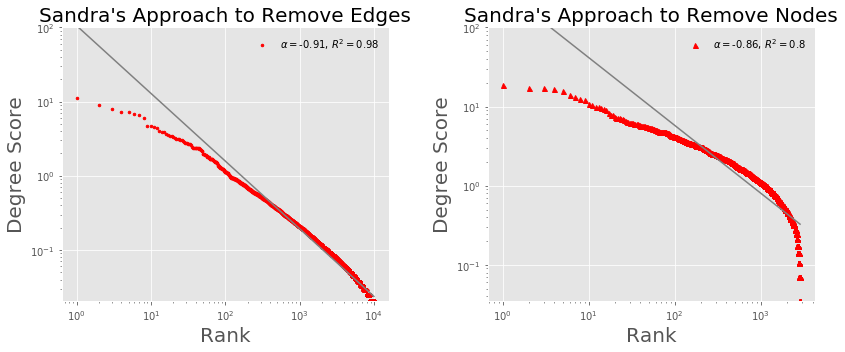

In [57]:
degree_score_gs0 = nx.degree_centrality(gs0)
degree_score_gs = nx.degree_centrality(gs)

fig = plt.figure(figsize=(12,5),facecolor='white')
ax = fig.add_subplot(1, 2, 1)
# powerRankPlot(uv_ratio, 'yellow', 's')
powerRankPlot(degree_score_gs0.values(), 'r', '.')
ax.set_title('Sandra\'s Approach to Remove Edges', fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)
ax = fig.add_subplot(1, 2, 2)
powerRankPlot(degree_score_gs.values(), 'r', '^')
ax.set_title('Sandra\'s Approach to Remove Nodes', fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)

plt.tight_layout()

In [428]:
# use a list of thresholds to filter nodes

# sandra network after cutting nodes whose reach is < 0.0001
# the network need to be rebuilt so that the edges can be re-filtered

# thresholds = [0.03, 0.02, 0.01, 0.003, 0.002, 0.001, 0.0003, 0.0002, 0.0001]
thresholds = [0.03, 0.0001]

degree_score_gs_list = []

for tindex in range(len(thresholds)):
    popnodes = []
    for node in gs0.nodes():
        if pvuv_dict[node][1] >= thresholds[tindex]:
            popnodes.append(node)
    print(thresholds[tindex], len(popnodes))

    gs = nx.Graph()
    for i in df_webster.index:
        source, target = eval(df_webster.edge[i])
        try:
            if source in popnodes:
                if target in popnodes:
                    source_uv = pvuv_dict[source][1] * total_uv
                    target_uv = pvuv_dict[target][1] * total_uv
                    phi = (df_webster.weight[i] * total_uv - source_uv * target_uv)\
                    / math.sqrt(source_uv * target_uv * (total_uv - source_uv) * (total_uv - target_uv))
                    t = phi * math.sqrt(total_uv - 2) / math.sqrt(1 - phi ** 2)
                    if t > 2.58:
                        gs.add_edge(source, target)
        except Exception as e:
            print(source, target, e)
    print(thresholds[tindex], nx.info(gs))

    degree_score_gs = nx.degree_centrality(gs)
    degree_score_gs_list.append(degree_score_gs)

0.03 60
0.03 Name: 
Type: Graph
Number of nodes: 58
Number of edges: 188
Average degree:   6.4828
0.0001 2868


/Users/zhicongchen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


0.0001 Name: 
Type: Graph
Number of nodes: 2865
Number of edges: 49061
Average degree:  34.2485


In [432]:
with open('degree_score_gs_list_population.pkl', 'wb') as output:
    pickle.dump(degree_score_gs_list, output, pickle.HIGHEST_PROTOCOL)

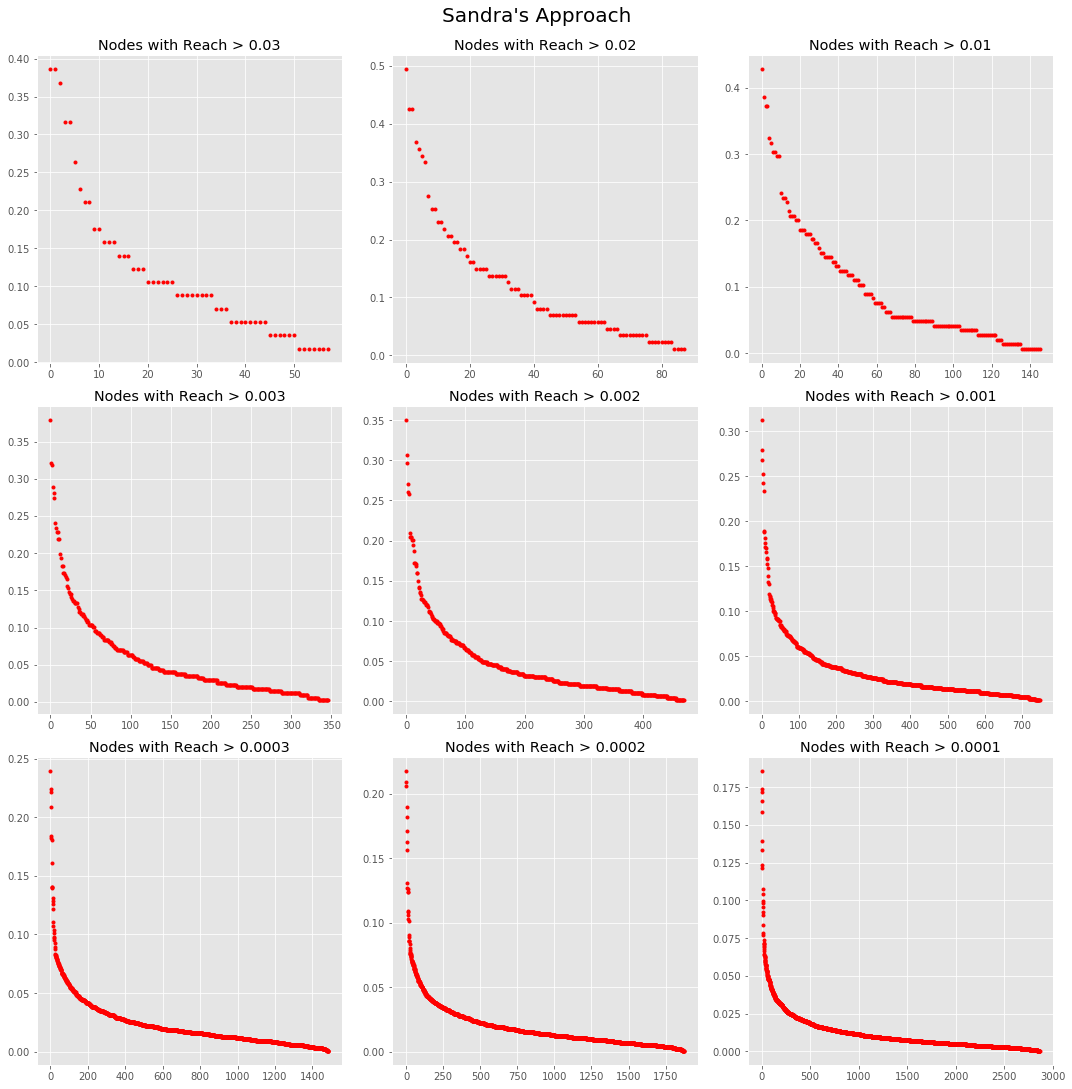

In [58]:
fig = plt.figure(figsize=(15,5 * len(thresholds)),facecolor='white')
fig.suptitle("Sandra\'s Approach", fontsize=20)
for tindex in range(len(thresholds)):
    ax = fig.add_subplot(len(thresholds), 3, tindex+1)
    degree_score_gs = degree_score_gs_list[tindex]
    ax.plot(range(len(degree_score_gs)), sorted(degree_score_gs.values(), reverse=True), '.r')
    ax.set_title('Nodes with Reach > ' + str(thresholds[tindex]))
    
fig.tight_layout()
fig.subplots_adjust(top=0.965)

## two approaches comparison

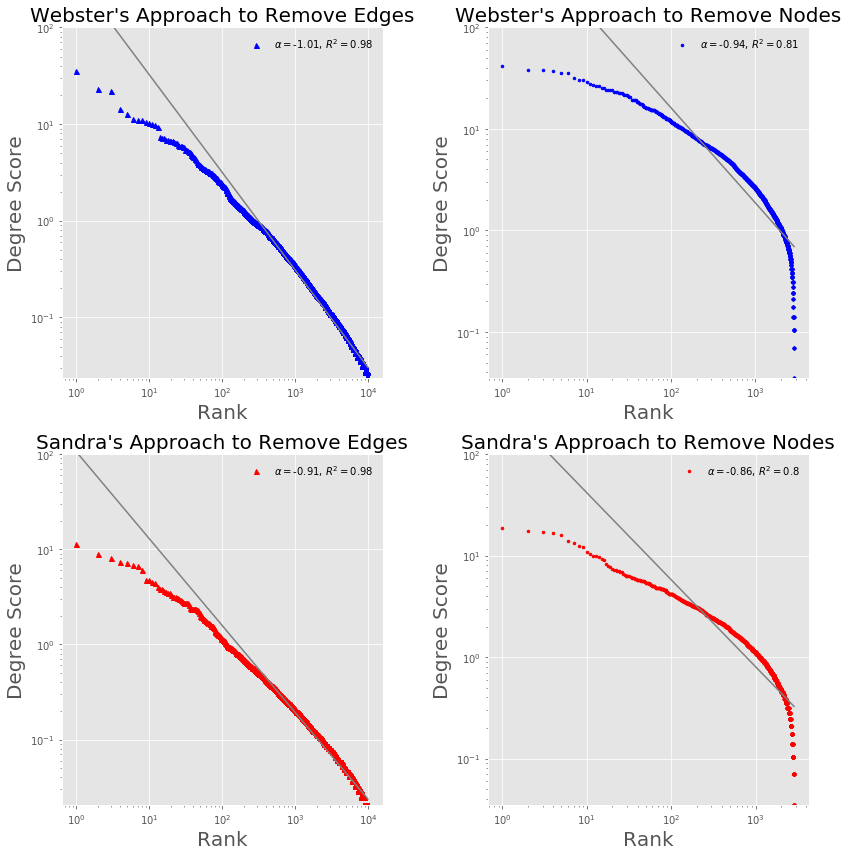

In [156]:
fig = plt.figure(figsize=(12,12),facecolor='white')
ax = fig.add_subplot(2, 2, 1)
# powerRankPlot(uv_ratio, 'yellow', 's')
powerRankPlot(degree_score_gw0.values(), 'b', '^')
ax.set_title('Webster\'s Approach to Remove Edges', fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)
ax = fig.add_subplot(2, 2, 2)
powerRankPlot(degree_score_gw.values(), 'b', '.')
ax.set_title('Webster\'s Approach to Remove Nodes', fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)
ax = fig.add_subplot(2, 2, 3)
# powerRankPlot(uv_ratio, 'yellow', 's')
powerRankPlot(degree_score_gs0.values(), 'r', '^')
ax.set_title('Sandra\'s Approach to Remove Edges', fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)
ax = fig.add_subplot(2, 2, 4)
powerRankPlot(degree_score_gs.values(), 'r', '.')
ax.set_title('Sandra\'s Approach to Remove Nodes', fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)

plt.tight_layout()

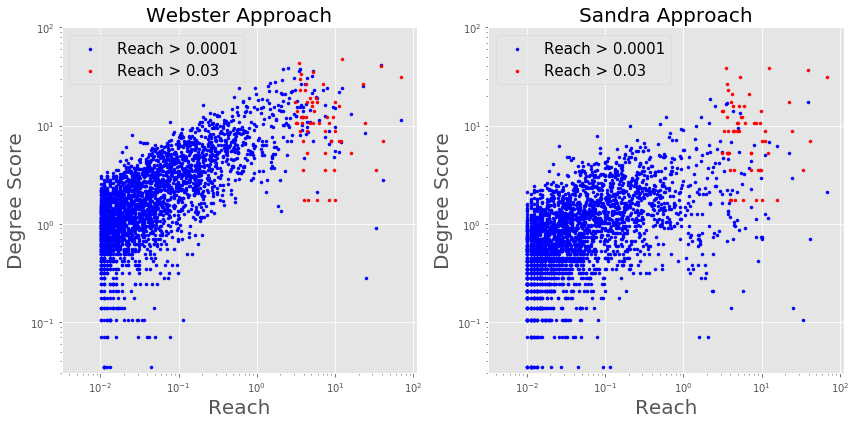

In [293]:
fig = plt.figure(figsize=(12, 6),facecolor='white')
ax = fig.add_subplot(121)
tindex=-1
degree_score_gw = degree_score_gw_list[tindex]
nodeslist = []
for key in degree_score_gw:
    nodeslist.append([key, pvuv_dict[key][1], degree_score_gw[key]])
nodesdf = pd.DataFrame(nodeslist, columns=['website', 'reach', 'degreescore'])
nodesdf = nodesdf.sort_values(by='reach', ascending=False)
ax.scatter(nodesdf['reach']*100, nodesdf['degreescore']*100, marker='.', color='b', label='Reach > ' + str(thresholds[tindex]))

tindex=0
degree_score_gw = degree_score_gw_list[tindex]
nodeslist = []
for key in degree_score_gw:
    nodeslist.append([key, pvuv_dict[key][1], degree_score_gw[key]])
nodesdf = pd.DataFrame(nodeslist, columns=['website', 'reach', 'degreescore'])
nodesdf = nodesdf.sort_values(by='reach', ascending=False)
ax.scatter(nodesdf['reach']*100, nodesdf['degreescore']*100, marker='.', color='r', label='Reach > ' + str(thresholds[tindex]))

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title("Webster Approach", fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Reach', fontsize=20)
ax.legend(loc=0, fontsize=15)
ax.set_ylim(0, 100)

ax = fig.add_subplot(122)
tindex=-1
degree_score_gs = degree_score_gs_list[tindex]
nodeslist = []
for key in degree_score_gs:
    nodeslist.append([key, pvuv_dict[key][1], degree_score_gs[key]])
nodesdf = pd.DataFrame(nodeslist, columns=['website', 'reach', 'degreescore'])
nodesdf = nodesdf.sort_values(by='reach', ascending=False)
ax.scatter(nodesdf['reach']*100, nodesdf['degreescore']*100, marker='.', color='b', label='Reach > ' + str(thresholds[tindex]))

tindex=0
degree_score_gs = degree_score_gs_list[tindex]
nodeslist = []
for key in degree_score_gs:
    nodeslist.append([key, pvuv_dict[key][1], degree_score_gs[key]])
nodesdf = pd.DataFrame(nodeslist, columns=['website', 'reach', 'degreescore'])
nodesdf = nodesdf.sort_values(by='reach', ascending=False)
ax.scatter(nodesdf['reach']*100, nodesdf['degreescore']*100, marker='.', color='r', label='Reach > ' + str(thresholds[tindex]))

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title("Sandra Approach", fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Reach', fontsize=20)
ax.legend(loc=0, fontsize=15)
ax.set_ylim(0, 100)

plt.tight_layout()

## flow approach

In [85]:
attentionflow = df[['user', 'time', 'website']].sort_values(by='time')

In [86]:
fg = flownetwork.constructFlowNetwork(attentionflow[['user', 'website']].values)
print(nx.info(fg))

Name: 
Type: DiGraph
Number of nodes: 25752
Number of edges: 64379
Average in degree:   2.5000
Average out degree:   2.5000


In [ ]:
def getAICI(G):
    '''
    return AI & CI
    Source: Wu and Zhang 2013 The decentralized flow structure of clickstreams on the web. EPJB
    '''
    H = flowBalancing(G)
    F1=nx.to_numpy_matrix(H)
    sourcep=H.nodes().index('source')
    sinkp=H.nodes().index('sink')
    F1oJ=F1[sourcep,]
    AI = F1.sum(0)

    if sinkp > sourcep:

        F1oJ=delete(F1oJ,sourcep,1)
        F1oJ=delete(F1oJ,sinkp-1,1)
        AI=delete(AI,sourcep,1)
        AI=delete(AI,sinkp-1,1)
        F1[sinkp,sinkp]=1
        M = F1 / F1.sum(axis=1)
        M = delete(M, sinkp, 0) 
        M = delete(M, sinkp, 1) 
        I = np.identity(len(M))
        U =  LA.inv( I - M)
        U = delete(U, sourcep, 0) 
        U = delete(U, sourcep, 1)
    else:
        F1oJ=delete(F1oJ,sinkp,1)
        F1oJ=delete(F1oJ,sourcep-1,1)
        AI=delete(AI,sinkp,1)
        AI=delete(AI,sourcep-1,1)
        F1[sinkp,sinkp]=1
        M = F1 / F1.sum(axis=1)
        M = delete(M, sinkp, 0) 
        M = delete(M, sinkp, 1) 
        I = np.identity(len(M))
        U =  LA.inv( I - M)
        U = delete(U, sourcep-1, 0) 
        U = delete(U, sourcep-1, 1)     
    def calculateCi(i):
        Gi = np.sum(np.dot(F1oJ,U[:,i]))/U[i,i]
        return np.sum(U[i,:])*Gi

    CI = map( lambda x:calculateCi(x),range(len(U)) )
    AI = AI.tolist()[0]
    return np.transpose(np.vstack((AI,CI)))

In [87]:
ai, ci = flownetwork.getAICI(fg)

In [62]:
flownetwork.alloRegressPlot(ai, ci, xlab='$A_i$', ylab='$C_i$', col='b', mark='.', loglog=True)

NameError: name 'ai' is not defined

In [117]:
nodes = []
for i in fg.nodes():
    if i != 'sink' and i != 'source':
        nodes.append(i)
pd.DataFrame(np.array([nodes, list(ai), list(ci)]).T, columns=['node', 'ai', 'ci']).to_csv('./dfaici.csv', index=False)

In [61]:
dfaici = pd.read_csv('dfaici.csv')
dfaici.head(10)

,node,ai,ci
0,qhimg.com,80771.0,8.101665e+04
1,37wan.com,1103.0,1.104000e+03
2,qq.com,4287363.0,4.291361e+06
3,sandai.net,22349.0,2.241124e+04
4,360.cn,517146.0,5.181244e+05
5,amap.com,84913.0,8.498411e+04
6,360buyimg.com,89739.0,8.999483e+04
7,gov.cn,9874.0,9.893045e+03
8,baidu.com,1697545.0,1.700215e+06
9,flurry.com,65694.0,6.579716e+04


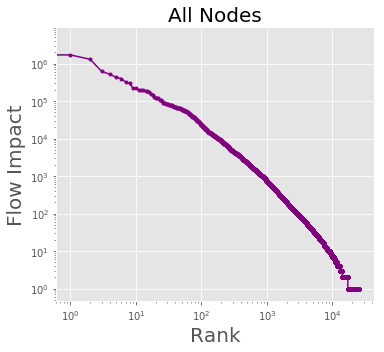

In [96]:
sortedci = dfaici.sort_values(by='ci', ascending=False)['ci'].values

fig = plt.figure(figsize=(10,5),facecolor='white')
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(len(sortedci)), sortedci, 'purple', marker='.')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('All Nodes', fontsize=20)
ax.set_ylabel('Flow Impact', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)
# ax = fig.add_subplot(1, 2, 2)
# ax.plot(range(60), sortedci[:60], 'sy')
# ax.text(60, sortedci[60], '3% reach', fontsize=20)
# ax.plot(range(60, 2865), sortedci[60:2865], '^r')
# ax.text(2865, sortedci[2865], '0.01% reach', fontsize=20)
# ax.plot(range(2865, len(sortedci)), sortedci[2865:], '.b')
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_title('Popular Nodes', fontsize=20)
# ax.set_ylabel('Flow Impact', fontsize=20)
# ax.set_xlabel('Rank', fontsize=20)

plt.tight_layout()

In [363]:
nodeslist = []
for line in dfaici.values:
    nodeslist.append([line[0], pvuv_dict[line[0]][1], line[2]])
nodesdf = pd.DataFrame(nodeslist, columns=['website', 'reach', 'flowimpact'])
nodesdf = nodesdf.sort_values(by='reach', ascending=False)

nodesdf.to_csv('./dfreachflowimpact.csv', index=False)

In [ ]:
df = pd.read_csv('./dfreachflowimpact.csv')

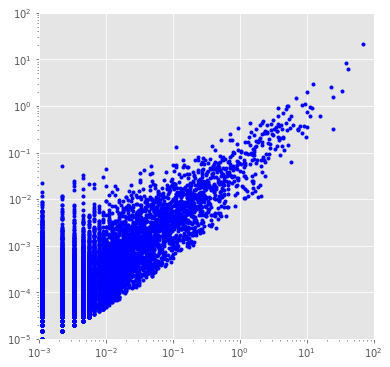

In [420]:
fig = plt.figure(figsize=(6, 6),facecolor='white')
df = pd.read_csv('./dfreachflowimpact.csv')
df['reach_ratio'] = 100* df['reach']
df['impact_ratio'] =100* df['flowimpact']/np.sum(df['flowimpact'])
plt.plot(df.reach_ratio, df.impact_ratio, '.b')
plt.xlim(0.001, 100)
plt.ylim(0.00001, 100)
plt.xscale('log')
plt.yscale('log')

## three approaches comparison

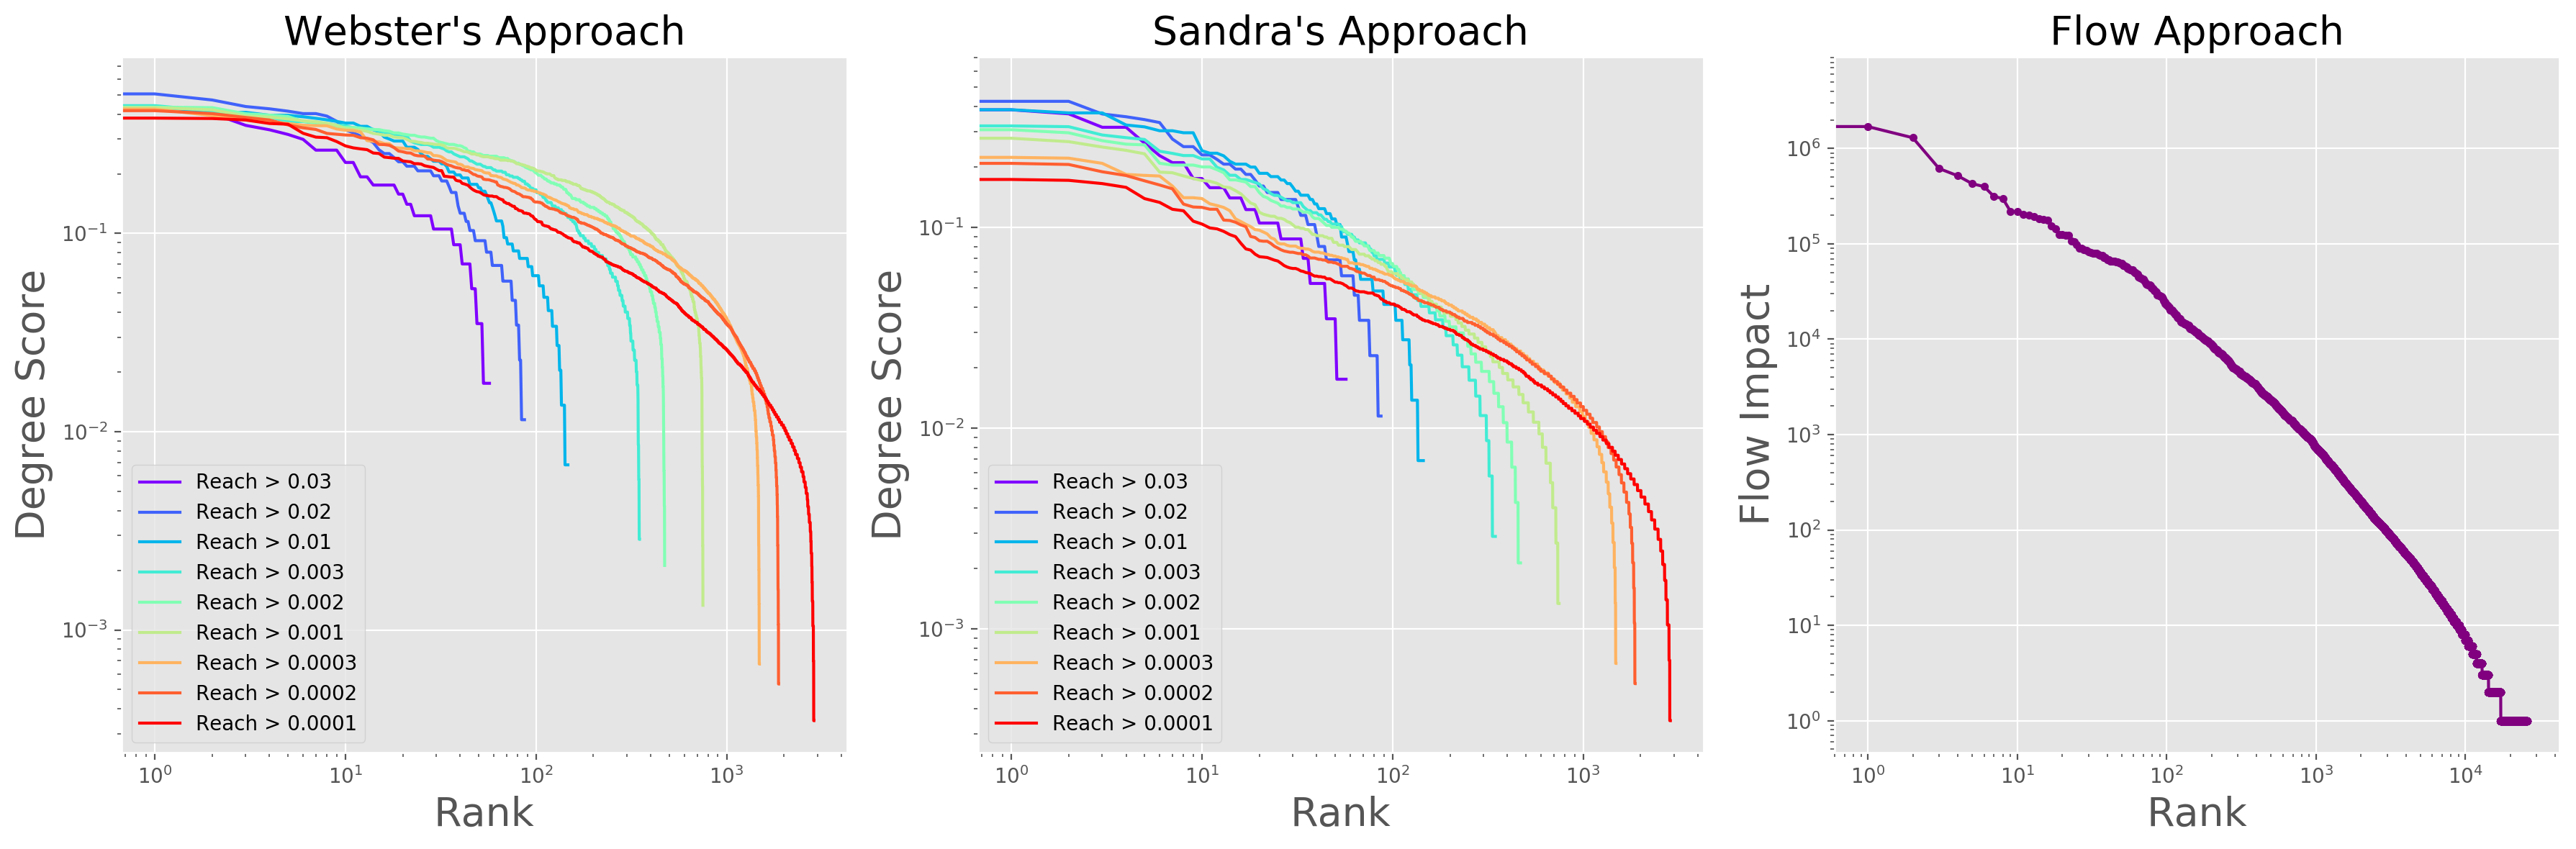

In [238]:
# 1. comparison between webster, sandra, flow approach

fig = plt.figure(figsize=(18, 6),facecolor='white', dpi=200)
# fig.suptitle("Sandra\'s Approach", fontsize=20)

ax = fig.add_subplot(131)
color=iter(cm.rainbow(np.linspace(0,1,n)))
for tindex in range(len(thresholds)):
    c = next(color)
    degree_score_gw = degree_score_gw_list[tindex]
    ax.plot(range(len(degree_score_gw)), sorted(degree_score_gw.values(), reverse=True), color=c, label='Reach > ' + str(thresholds[tindex]))
    
    ax.set_yscale('log')
    ax.set_xscale('log')

# ax.set_title('Nodes with Reach > ' + str(thresholds[tindex]))
# fig.tight_layout()
# fig.subplots_adjust(top=0.965)

ax.set_title("Webster\'s Approach", fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)
ax.legend(loc=0)

ax = fig.add_subplot(132)
color=iter(cm.rainbow(np.linspace(0,1,n)))
for tindex in range(len(thresholds)):
    c = next(color)
    degree_score_gs = degree_score_gs_list[tindex]
    ax.plot(range(len(degree_score_gs)), sorted(degree_score_gs.values(), reverse=True), color=c, label='Reach > ' + str(thresholds[tindex]))
    
    ax.set_yscale('log')
    ax.set_xscale('log')

# ax.set_title('Nodes with Reach > ' + str(thresholds[tindex]))
# fig.tight_layout()
# fig.subplots_adjust(top=0.965)

ax.set_title("Sandra\'s Approach", fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)
ax.legend(loc=0)

ax = fig.add_subplot(133)
ax.set_title('Flow Approach', fontsize=20)
ax.plot(range(len(sortedci)), sortedci, 'purple', marker='.')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylabel('Flow Impact', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)

plt.tight_layout()

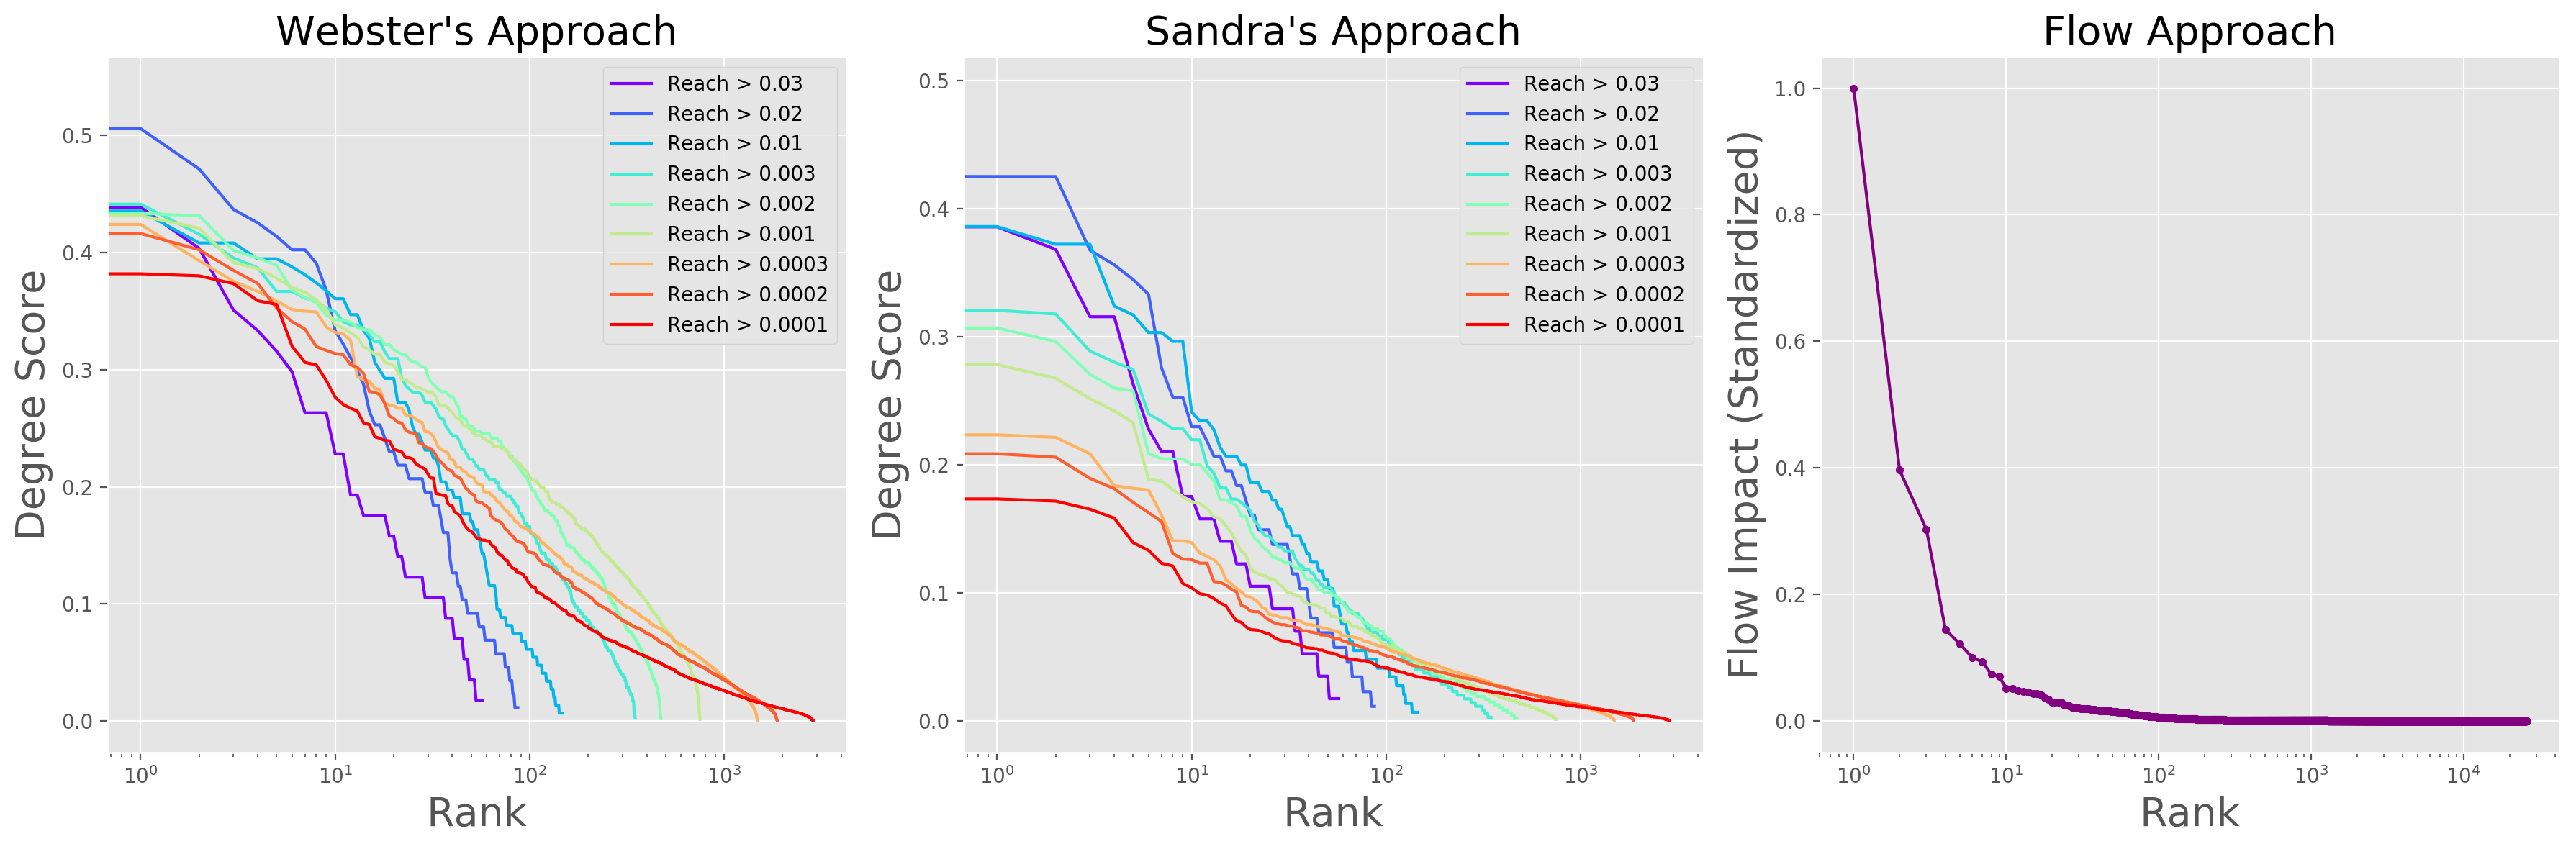

In [411]:
# 2. log scale to x, y

fig = plt.figure(figsize=(18, 6),facecolor='white', dpi=200)

n = len(thresholds)

# fig.suptitle("Sandra\'s Approach", fontsize=20)
ax = fig.add_subplot(131)
color=iter(cm.rainbow(np.linspace(0,1,n)))
for tindex in range(n):
    degree_score_gw = degree_score_gw_list[tindex]
    c = next(color)
    ax.plot(range(len(degree_score_gw)), sorted(degree_score_gw.values(), reverse=True), color=c, label='Reach > ' + str(thresholds[tindex]))
    
    # ax.set_yscale('log')
    ax.set_xscale('log')

# ax.set_title('Nodes with Reach > ' + str(thresholds[tindex]))
# fig.tight_layout()
# fig.subplots_adjust(top=0.965)

ax.set_title("Webster\'s Approach", fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)
ax.legend(loc=0)

ax = fig.add_subplot(132)
color=iter(cm.rainbow(np.linspace(0,1,n)))
for tindex in range(n):
    degree_score_gs = degree_score_gs_list[tindex]
    c = next(color)
    ax.plot(range(len(degree_score_gs)), sorted(degree_score_gs.values(), reverse=True), color=c, label='Reach > ' + str(thresholds[tindex]))
    
    # ax.set_yscale('log')
    ax.set_xscale('log')

# ax.set_title('Nodes with Reach > ' + str(thresholds[tindex]))
# fig.tight_layout()
# fig.subplots_adjust(top=0.965)

ax.set_title("Sandra\'s Approach", fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)
ax.legend(loc=0)

ax = fig.add_subplot(133)
ax.set_title('Flow Approach', fontsize=20)
ax.plot(np.arange(len(sortedci))+1, sortedci / np.sum(sortedci), 'purple', marker='.')

# ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_ylim(-0.025, 0.5)
# ax.set_xlim(-1, 100000)

ax.set_ylabel('Flow Impact (Standardized)', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)

plt.tight_layout()

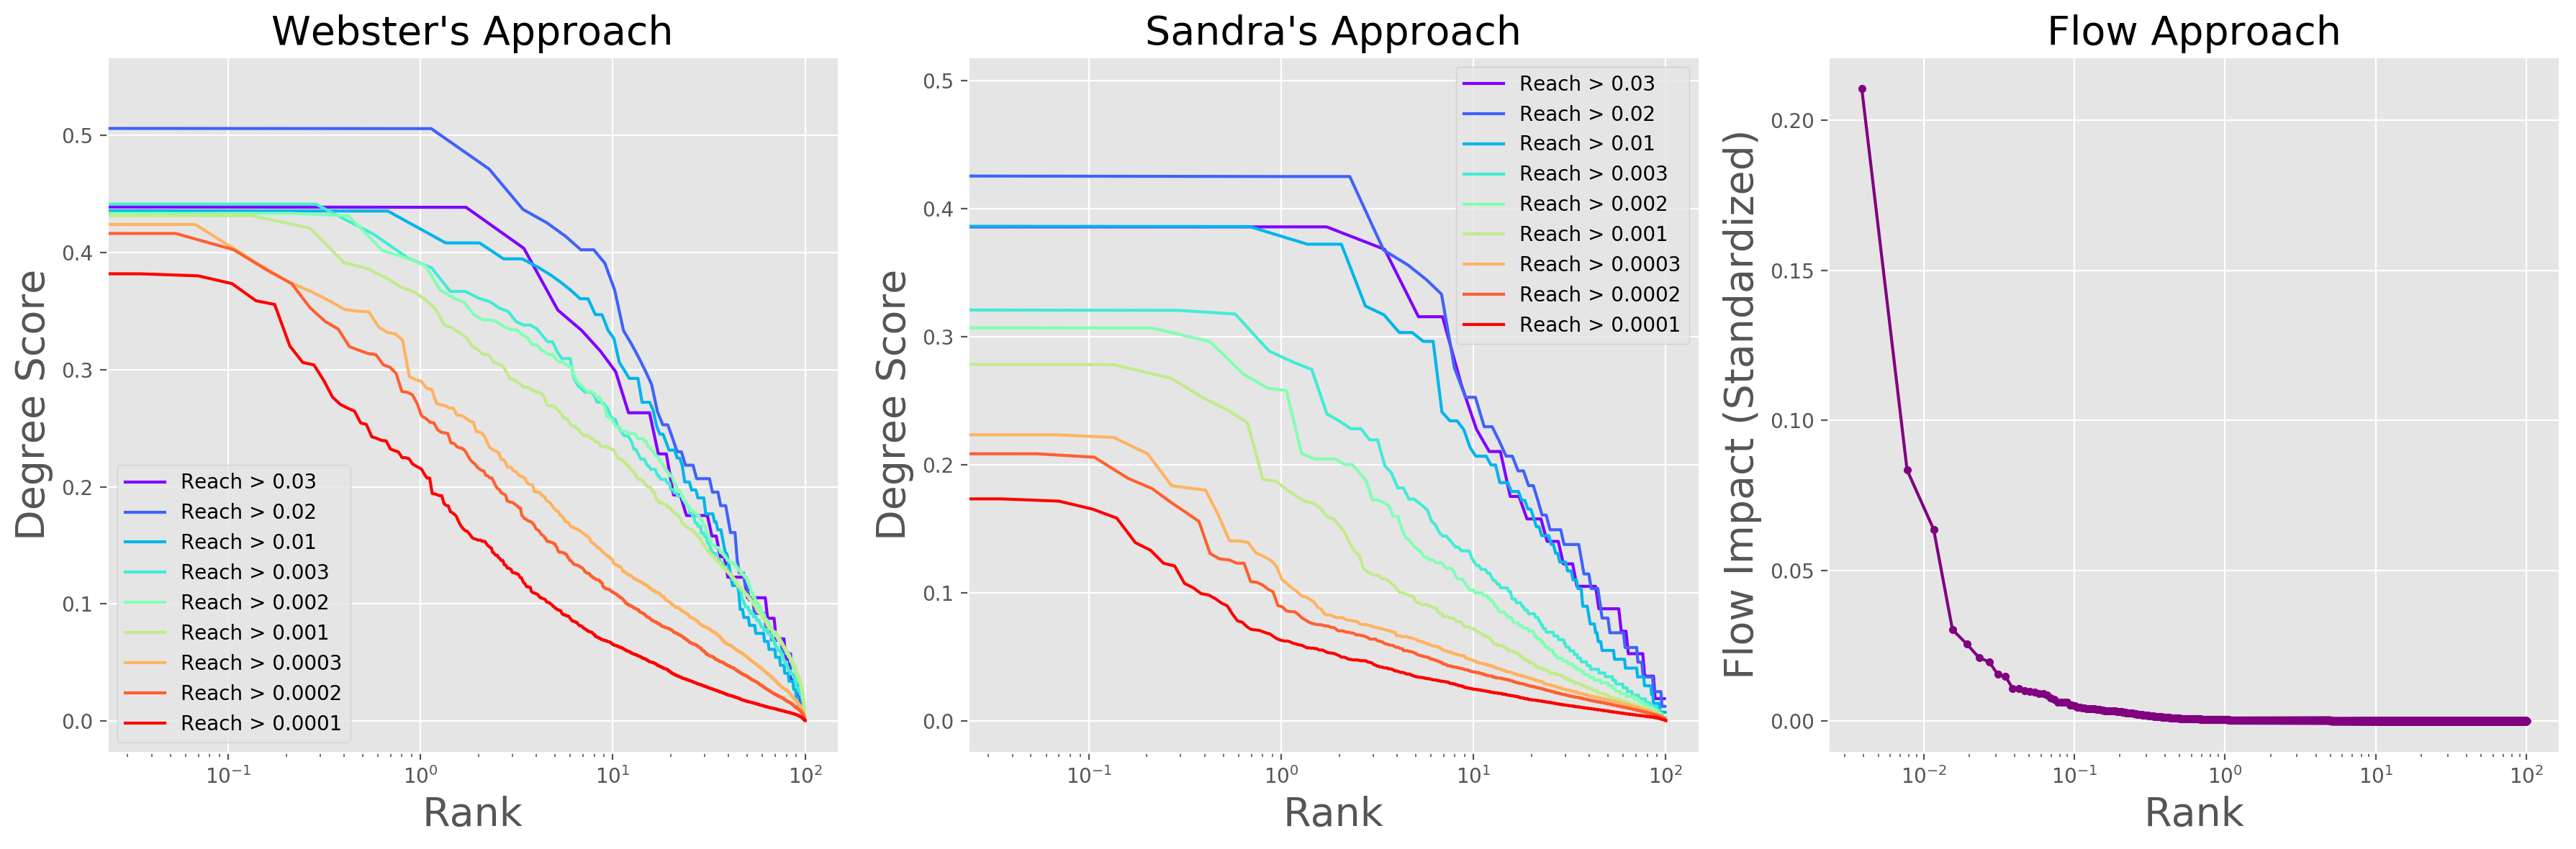

In [418]:
# 3. rescale x-axis to (0, 100)

fig = plt.figure(figsize=(18, 6),facecolor='white', dpi=200)

n = len(thresholds)

# fig.suptitle("Sandra\'s Approach", fontsize=20)
ax = fig.add_subplot(131)
color=iter(cm.rainbow(np.linspace(0,1,n)))
for tindex in range(n):
    degree_score_gw = degree_score_gw_list[tindex]
    c = next(color)
    ax.plot(np.arange(len(degree_score_gw)) / len(degree_score_gw) * 100, sorted(degree_score_gw.values(), reverse=True), color=c, label='Reach > ' + str(thresholds[tindex]))
    
    # ax.set_yscale('log')
    ax.set_xscale('log')

# ax.set_title('Nodes with Reach > ' + str(thresholds[tindex]))
# fig.tight_layout()
# fig.subplots_adjust(top=0.965)

ax.set_title("Webster\'s Approach", fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)
ax.legend(loc=0)

ax = fig.add_subplot(132)
color=iter(cm.rainbow(np.linspace(0,1,n)))
for tindex in range(n):
    degree_score_gs = degree_score_gs_list[tindex]
    c = next(color)
    ax.plot(np.arange(len(degree_score_gs)) / len(degree_score_gs) * 100, sorted(degree_score_gs.values(), reverse=True), color=c, label='Reach > ' + str(thresholds[tindex]))
    
    # ax.set_yscale('log')
    ax.set_xscale('log')

# ax.set_title('Nodes with Reach > ' + str(thresholds[tindex]))
# fig.tight_layout()
# fig.subplots_adjust(top=0.965)

ax.set_title("Sandra\'s Approach", fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)
ax.legend(loc=0)

ax = fig.add_subplot(133)
ax.set_title('Flow Approach', fontsize=20)
ax.plot((np.arange(len(sortedci))+1) / len(sortedci) * 100, sortedci / np.sum(sortedci), 'purple', marker='.')

# ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_ylim(-0.025, 0.5)
# ax.set_xlim(-1, 100000)

ax.set_ylabel('Flow Impact (Standardized)', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)

plt.tight_layout()

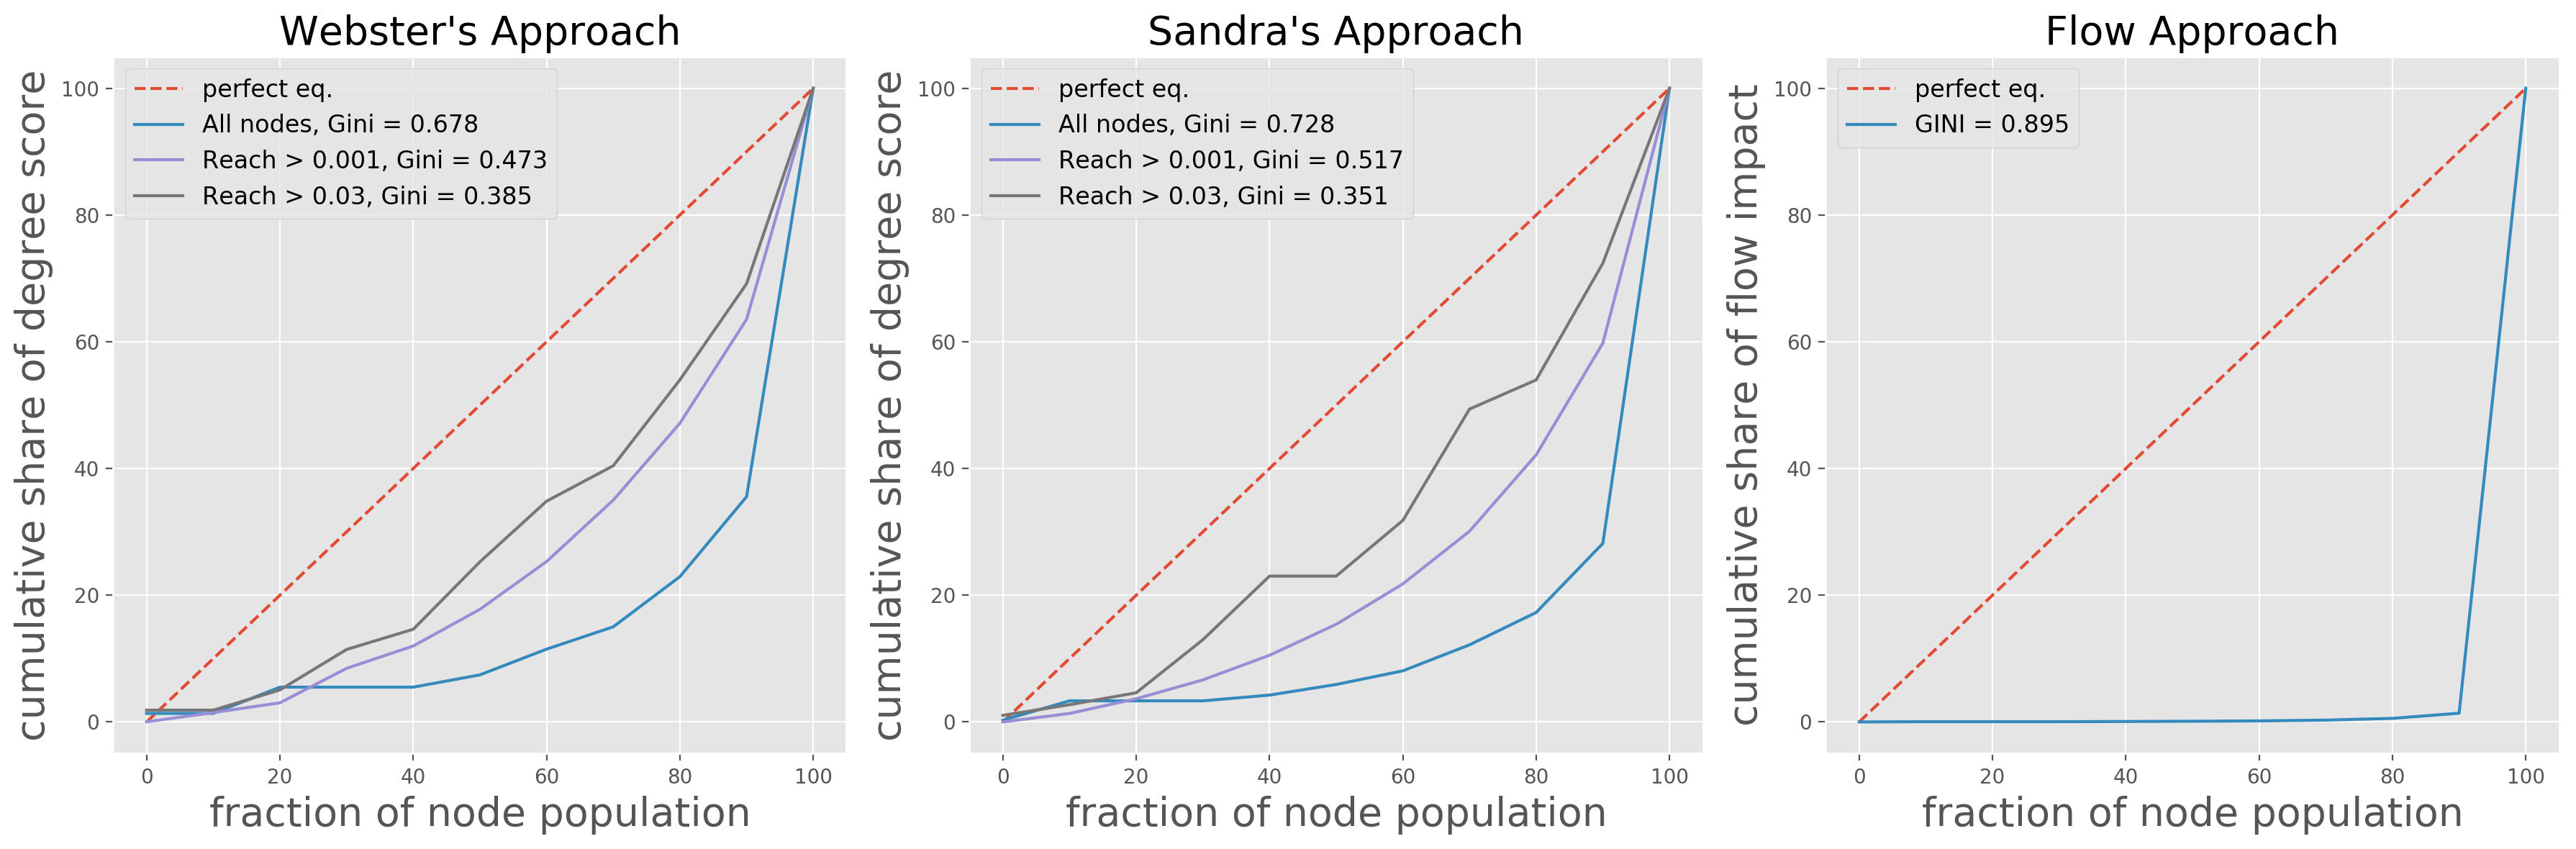

In [170]:
# gini coefficient

# v is np.array
def gini_coefficient(v):
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return bins, yvals, gini_val

fig = plt.figure(figsize=(18, 6),facecolor='white', dpi=200)

ax = fig.add_subplot(1,3,1)
# ax.axhline(50, 0, 100, ls = '--', color='grey')
ax.plot(bins, bins, '--', label="perfect eq.")
bins, result, gini_val = gini_coefficient(np.array(list(degree_score_gs0.values())))
ax.plot(bins, result, label='All nodes, Gini = %.3f' % (gini_val))
bins, result, gini_val = gini_coefficient(np.array(list(degree_score_gs_list[-1].values())))
ax.plot(bins, result, label='Reach > 0.001, Gini = %.3f' % (gini_val))
bins, result, gini_val = gini_coefficient(np.array(list(degree_score_gs_list[0].values())))
ax.plot(bins, result, label='Reach > 0.03, Gini = %.3f' % (gini_val))
ax.set_xlabel('fraction of node population', fontsize=20)
ax.set_ylabel('cumulative share of degree score', fontsize=20)
ax.set_title('Webster\'s Approach', fontsize=20)
ax.legend(fontsize=12)

ax = fig.add_subplot(1,3,2)
# ax.axhline(50, 0, 100, ls = '--', color='grey')
ax.plot(bins, bins, '--', label="perfect eq.")
bins, result, gini_val = gini_coefficient(np.array(list(degree_score_gw0.values())))
ax.plot(bins, result, label='All nodes, Gini = %.3f' % (gini_val))
bins, result, gini_val = gini_coefficient(np.array(list(degree_score_gw_list[-1].values())))
ax.plot(bins, result, label='Reach > 0.001, Gini = %.3f' % (gini_val))
bins, result, gini_val = gini_coefficient(np.array(list(degree_score_gw_list[0].values())))
ax.plot(bins, result, label='Reach > 0.03, Gini = %.3f' % (gini_val))
ax.set_xlabel('fraction of node population', fontsize=20)
ax.set_ylabel('cumulative share of degree score', fontsize=20)
ax.set_title('Sandra\'s Approach', fontsize=20)
ax.legend(fontsize=12)

ax = fig.add_subplot(1,3,3)
# ax.axhline(50, 0, 100, ls = '--', color='grey')
bins, result, gini_val = gini_coefficient(np.array(sortedci))
ax.plot(bins, bins, '--', label="perfect eq.")
ax.plot(bins, result, label="GINI = %.3f" % (gini_val))
ax.set_xlabel('fraction of node population', fontsize=20)
ax.set_ylabel('cumulative share of flow impact', fontsize=20)
ax.set_title('Flow Approach', fontsize=20)
ax.legend(fontsize=12)

plt.tight_layout()

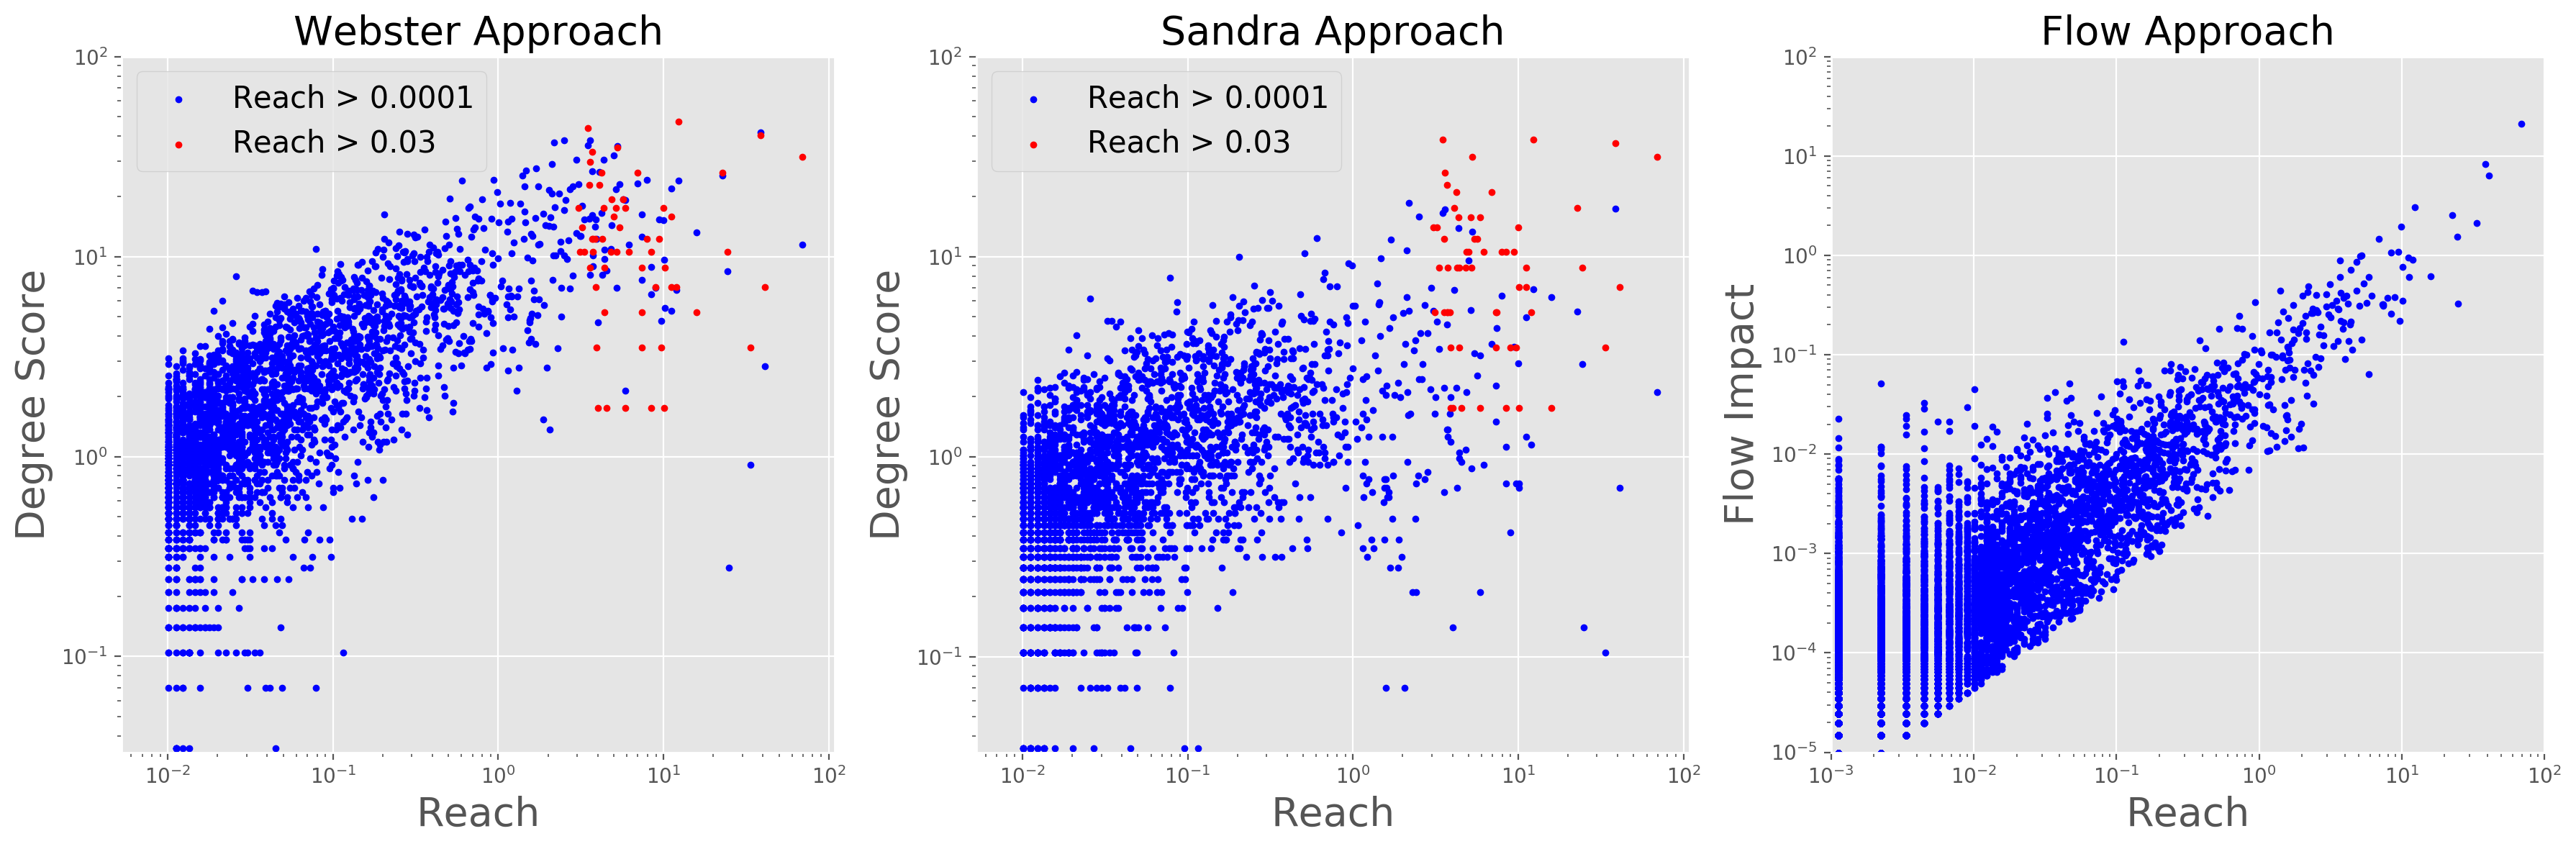

In [419]:
# the correlation between degree score and reach

fig = plt.figure(figsize=(18, 6),facecolor='white', dpi=200)
ax = fig.add_subplot(131)
tindex=-1
degree_score_gw = degree_score_gw_list[tindex]
nodeslist = []
for key in degree_score_gw:
    nodeslist.append([key, pvuv_dict[key][1], degree_score_gw[key]])
nodesdf = pd.DataFrame(nodeslist, columns=['website', 'reach', 'degreescore'])
nodesdf = nodesdf.sort_values(by='reach', ascending=False)
ax.scatter(nodesdf['reach']*100, nodesdf['degreescore']*100, marker='.', color='b', label='Reach > ' + str(thresholds[tindex]))

tindex=0
degree_score_gw = degree_score_gw_list[tindex]
nodeslist = []
for key in degree_score_gw:
    nodeslist.append([key, pvuv_dict[key][1], degree_score_gw[key]])
nodesdf = pd.DataFrame(nodeslist, columns=['website', 'reach', 'degreescore'])
nodesdf = nodesdf.sort_values(by='reach', ascending=False)
ax.scatter(nodesdf['reach']*100, nodesdf['degreescore']*100, marker='.', color='r', label='Reach > ' + str(thresholds[tindex]))

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title("Webster\'s Approach", fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Reach', fontsize=20)
ax.legend(loc=0, fontsize=15)
ax.set_ylim(0, 100)

ax = fig.add_subplot(132)
tindex=-1
degree_score_gs = degree_score_gs_list[tindex]
nodeslist = []
for key in degree_score_gs:
    nodeslist.append([key, pvuv_dict[key][1], degree_score_gs[key]])
nodesdf = pd.DataFrame(nodeslist, columns=['website', 'reach', 'degreescore'])
nodesdf = nodesdf.sort_values(by='reach', ascending=False)
ax.scatter(nodesdf['reach']*100, nodesdf['degreescore']*100, marker='.', color='b', label='Reach > ' + str(thresholds[tindex]))

tindex=0
degree_score_gs = degree_score_gs_list[tindex]
nodeslist = []
for key in degree_score_gs:
    nodeslist.append([key, pvuv_dict[key][1], degree_score_gs[key]])
nodesdf = pd.DataFrame(nodeslist, columns=['website', 'reach', 'degreescore'])
nodesdf = nodesdf.sort_values(by='reach', ascending=False)
ax.scatter(nodesdf['reach']*100, nodesdf['degreescore']*100, marker='.', color='r', label='Reach > ' + str(thresholds[tindex]))

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title("Sandra\'s Approach", fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Reach', fontsize=20)
ax.legend(loc=0, fontsize=15)
ax.set_ylim(0, 100)

ax = fig.add_subplot(133)
nodeslist = []
for line in dfaici.values:
    nodeslist.append([line[0], pvuv_dict[line[0]][1], line[2]])
nodesdf = pd.DataFrame(nodeslist, columns=['website', 'reach', 'flowimpact'])
nodesdf = nodesdf.sort_values(by='reach', ascending=False)

nodesdf['reach_ratio'] = 100* nodesdf['reach']
nodesdf['impact_ratio'] =100* nodesdf['flowimpact']/np.sum(nodesdf['flowimpact'])
ax.scatter(nodesdf['reach_ratio'], nodesdf['impact_ratio'], marker='.', color='b', label='Reach > ' + str(thresholds[tindex]))

ax.set_title("Flow Approach", fontsize=20)
ax.set_ylabel('Flow Impact', fontsize=20)
ax.set_xlabel('Reach', fontsize=20)
# ax.legend(loc=0, fontsize=15)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(0.00001, 100)
ax.set_xlim(0.001, 100)

plt.tight_layout()

# 2018.6.7

## / available users

把分母改成“available users"(= N of users visiting site A + N of users visiting site B)，看看是否趋向均匀分布

In [442]:
# 把分母改成“available users"(= N of users visiting site A + N of users visiting site B)，看看是否趋向均匀分布

# use a list of thresholds to filter nodes the network need to be rebuilt so that the edges can be re-filtered
# webster network after cutting nodes whose reach is < 0.03 while sandra use 0.0001

thresholds = [0.03, 0.0001]

# webster approach
degree_score_gw_list = []
for tindex in range(len(thresholds)):
    popnodes = []
    for node in gw0.nodes():
        if pvuv_dict[node][1] >= thresholds[tindex]:
            popnodes.append(node)
    print(thresholds[tindex], len(popnodes))

    gw = nx.Graph()
    for i in df_webster.index:
        source, target = eval(df_webster.edge[i])
        if source in popnodes:
            if target in popnodes:
                # source_uv_rate = pvuv_dict[source][1]
                source_uv = pvuv_dict[source][1] * total_uv
                # target_uv_rate = pvuv_dict[target][1]
                target_uv = pvuv_dict[target][1] * total_uv
                weight = df_webster.weight[i] / (source_uv + target_uv)
                
                # debug
                # if source == '10086.cn':
                #    if weight >= source_uv_rate*target_uv_rate:
                #        print(source, target, source_uv_rate*target_uv_rate, weight)
                
                if weight >= source_uv_rate*target_uv_rate:
                    gw.add_edge(source, target)
    print(thresholds[tindex], nx.info(gw))

    degree_score_gw = nx.degree_centrality(gw)
    degree_score_gw_list.append(degree_score_gw)

0.03 60
0.03 Name: 
Type: Graph
Number of nodes: 60
Number of edges: 1770
Average degree:  59.0000
0.0001 2871
0.0001 Name: 
Type: Graph
Number of nodes: 2870
Number of edges: 217157
Average degree: 151.3289


In [443]:
with open('degree_score_gw_list_availableusers.pkl', 'wb') as output:
    pickle.dump(degree_score_gw_list, output, pickle.HIGHEST_PROTOCOL)

In [488]:
# sandra approach

thresholds = [0.03, 0.0001]

degree_score_gs_list = []

for tindex in range(len(thresholds)):
    popnodes = []
    for node in gs0.nodes():
        if pvuv_dict[node][1] >= thresholds[tindex]:
            popnodes.append(node)
    print(thresholds[tindex], len(popnodes))

    gs = nx.Graph()
    for i in df_webster.index:
        source, target = eval(df_webster.edge[i])
        try:
            if source in popnodes:
                if target in popnodes:
                    source_uv = pvuv_dict[source][1] * total_uv
                    target_uv = pvuv_dict[target][1] * total_uv
                    N = source_uv + target_uv
                    phi = (df_webster.weight[i] * N - source_uv * target_uv)\
                    / math.sqrt(source_uv * target_uv * (N - source_uv) * (N - target_uv))
                    t = phi * math.sqrt(N - 2) / math.sqrt(1 - phi ** 2)
                    if t > 2.58:
                        gs.add_edge(source, target)
        except Exception as e:
            print(source, target, e)
    print(thresholds[tindex], nx.info(gs))

    degree_score_gs = nx.degree_centrality(gs)
    degree_score_gs_list.append(degree_score_gs)

0.03 60
0.03 Name: 
Type: Graph
Number of nodes: 10
Number of edges: 7
Average degree:   1.4000
0.0001 2868


/Users/zhicongchen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


0.0001 Name: 
Type: Graph
Number of nodes: 106
Number of edges: 73
Average degree:   1.3774


In [489]:
with open('degree_score_gs_list_availableusers.pkl', 'wb') as output:
    pickle.dump(degree_score_gs_list, output, pickle.HIGHEST_PROTOCOL)

## compare with / population

webster's approach v.s. sandra's approach

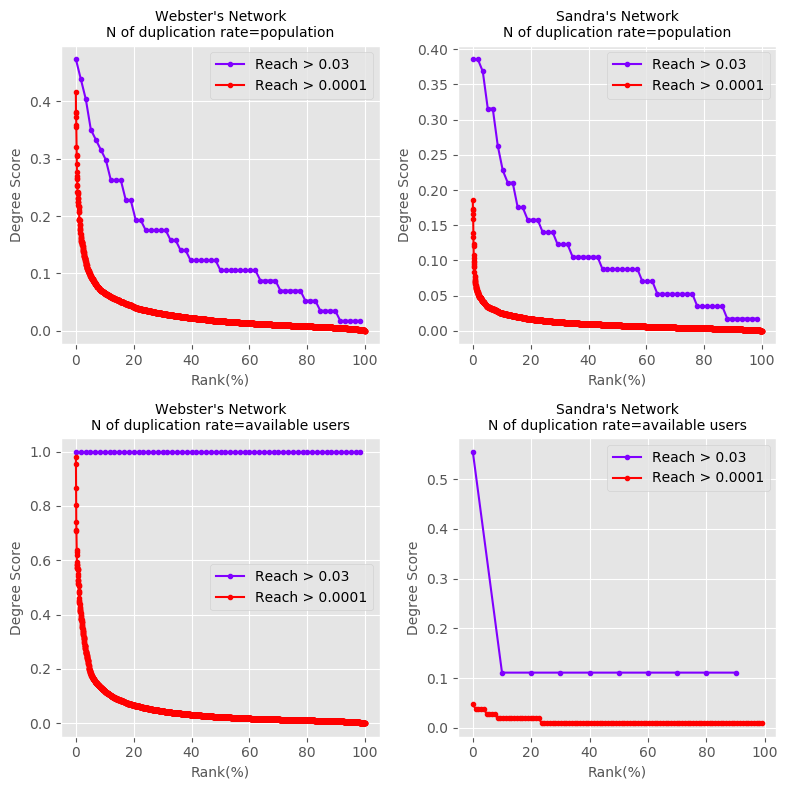

In [511]:
# webster's approach v.s. sandra's approach
fig = plt.figure(figsize=(8, 8),facecolor='white', dpi=100)

n = len(thresholds)
fs = 10

ax = fig.add_subplot(221)
with open('degree_score_gw_list_population.pkl', 'rb') as input:
    degree_score_gw_list = pickle.load(input)
color=iter(cm.rainbow(np.linspace(0,1,n)))
for tindex in range(n):
    degree_score_gw = degree_score_gw_list[tindex]
    c = next(color)
    ax.plot(np.arange(len(degree_score_gw)) / len(degree_score_gw) * 100, sorted(degree_score_gw.values(), reverse=True), marker='.', color=c, label='Reach > ' + str(thresholds[tindex]))
#     ax.plot(np.arange(len(degree_score_gw)), sorted(degree_score_gw.values(), reverse=True), color=c, label='Reach > ' + str(thresholds[tindex]))
    
#     ax.set_yscale('log')
#     ax.set_xscale('log')

# ax.set_title('Nodes with Reach > ' + str(thresholds[tindex]))
# fig.tight_layout()
# fig.subplots_adjust(top=0.965)

ax.set_title("Webster\'s Network\nN of duplication rate=population", fontsize=fs)
ax.set_ylabel('Degree Score', fontsize=fs)
ax.set_xlabel('Rank(%)', fontsize=fs)
ax.legend()

ax = fig.add_subplot(222)
with open('degree_score_gs_list_population.pkl', 'rb') as input:
    degree_score_gs_list = pickle.load(input)
color=iter(cm.rainbow(np.linspace(0,1,n)))
for tindex in range(n):
    degree_score_gs = degree_score_gs_list[tindex]
    c = next(color)
    ax.plot(np.arange(len(degree_score_gs)) / len(degree_score_gs) * 100, sorted(degree_score_gs.values(), reverse=True), marker='.', color=c, label='Reach > ' + str(thresholds[tindex]))
#     ax.plot(np.arange(len(degree_score_gs)), sorted(degree_score_gs.values(), reverse=True), color=c, label='Reach > ' + str(thresholds[tindex]))
    
#     ax.set_yscale('log')
#     ax.set_xscale('log')

# ax.set_title('Nodes with Reach > ' + str(thresholds[tindex]))
# fig.tight_layout()
# fig.subplots_adjust(top=0.965)

ax.set_title("Sandra\'s Network\nN of duplication rate=population", fontsize=fs)
ax.set_ylabel('Degree Score', fontsize=fs)
ax.set_xlabel('Rank(%)', fontsize=fs)
ax.legend()

ax = fig.add_subplot(223)
with open('degree_score_gw_list_availableusers.pkl', 'rb') as input:
    degree_score_gw_list = pickle.load(input)
color=iter(cm.rainbow(np.linspace(0,1,n)))
for tindex in range(n):
    degree_score_gw = degree_score_gw_list[tindex]
    c = next(color)
    ax.plot(np.arange(len(degree_score_gw)) / len(degree_score_gw) * 100, sorted(degree_score_gw.values(), reverse=True), marker='.', color=c, label='Reach > ' + str(thresholds[tindex]))
#     ax.plot(np.arange(len(degree_score_gw)), sorted(degree_score_gw.values(), reverse=True), color=c, label='Reach > ' + str(thresholds[tindex]))
    
#     ax.set_yscale('log')
#     ax.set_xscale('log')

# ax.set_title('Nodes with Reach > ' + str(thresholds[tindex]))
# fig.tight_layout()
# fig.subplots_adjust(top=0.965)

ax.set_title("Webster\'s Network\nN of duplication rate=available users", fontsize=fs)
ax.set_ylabel('Degree Score', fontsize=fs)
ax.set_xlabel('Rank(%)', fontsize=fs)
ax.legend()

ax = fig.add_subplot(224)
with open('degree_score_gs_list_availableusers.pkl', 'rb') as input:
    degree_score_gs_list = pickle.load(input)
color=iter(cm.rainbow(np.linspace(0,1,n)))
for tindex in range(n):
    degree_score_gs = degree_score_gs_list[tindex]
    c = next(color)
    ax.plot(np.arange(len(degree_score_gs)) / len(degree_score_gs) * 100, sorted(degree_score_gs.values(), reverse=True), marker='.', color=c, label='Reach > ' + str(thresholds[tindex]))
#     ax.plot(np.arange(len(degree_score_gs)), sorted(degree_score_gs.values(), reverse=True), color=c, label='Reach > ' + str(thresholds[tindex]))
    
#     ax.set_yscale('log')
#     ax.set_xscale('log')

# ax.set_title('Nodes with Reach > ' + str(thresholds[tindex]))
# fig.tight_layout()
# fig.subplots_adjust(top=0.965)

ax.set_title("Sandra\'s Network\nN of duplication rate=available users", fontsize=fs)
ax.set_ylabel('Degree Score', fontsize=fs)
ax.set_xlabel('Rank(%)', fontsize=fs)
ax.legend()

plt.tight_layout()

In [501]:
len(degree_score_gw.values())

58

# 2018.6.9

可否给我九张图拼在一起的图：3*3的方式。三列分别是Webster‘s Approach, Sandra's Approach, Flow Approach
三行分别是：
- 第一行，duplication(0-100,不取对数）和rank（0到100）
- 第二行，duplication和reach
- 第三行，duplication的gini系数图。这三张图表明我们所做过的所有努力。

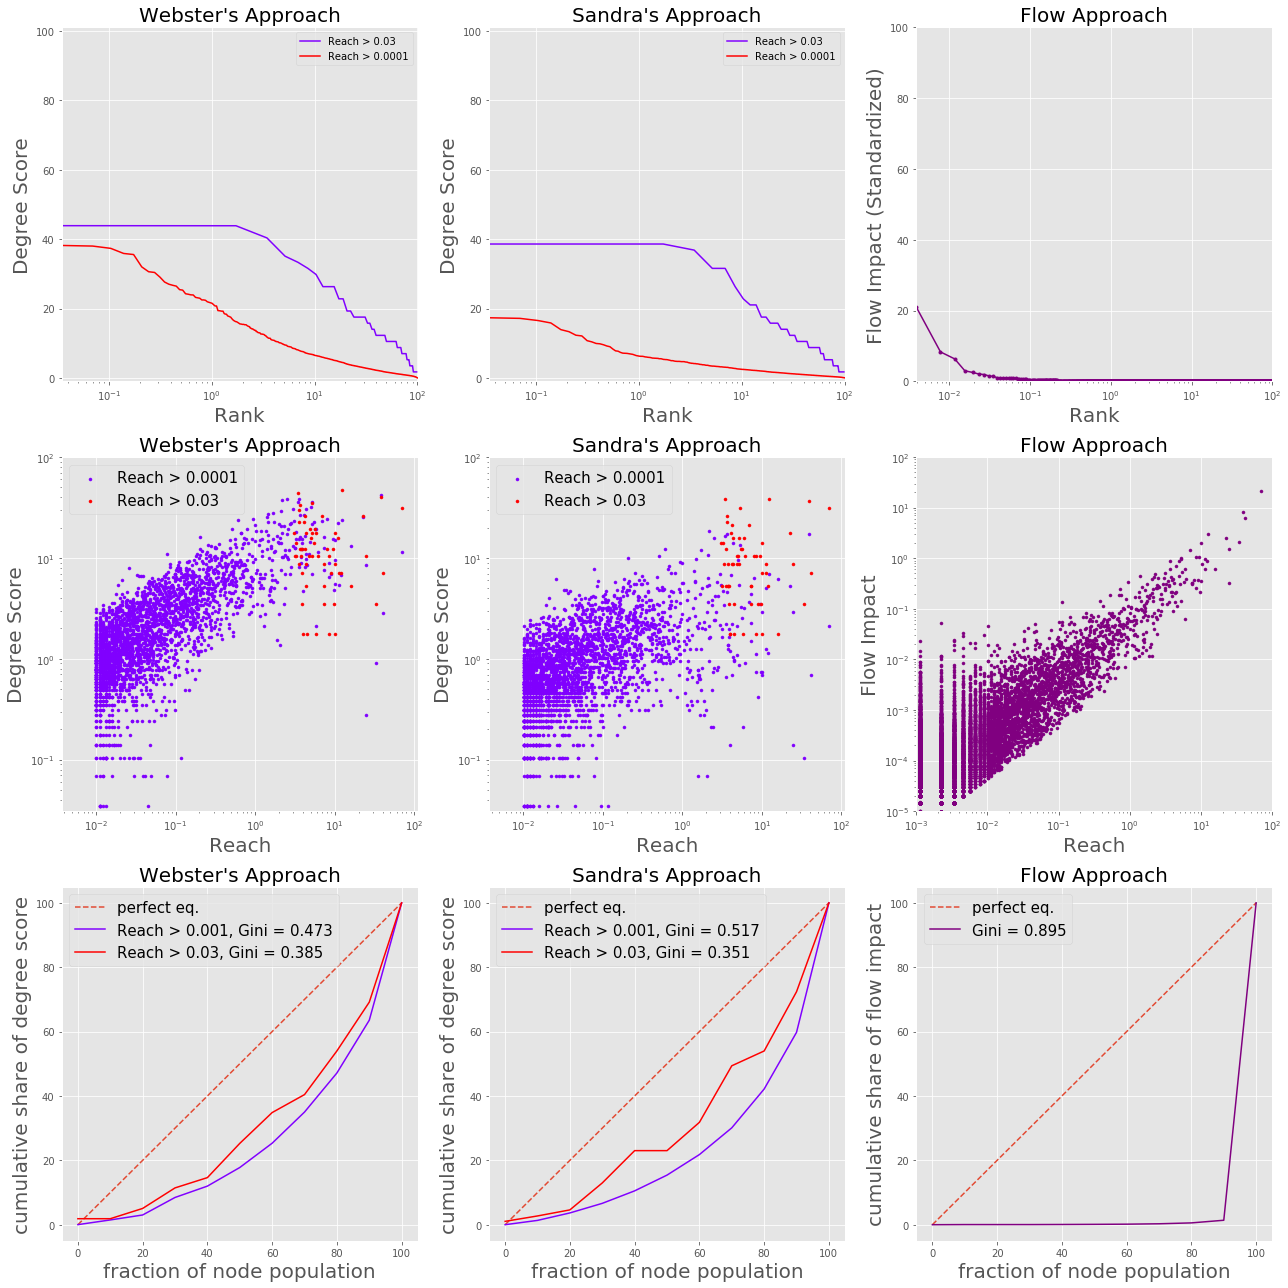

In [39]:
# duplication(0-100,不取对数）和rank（0到100）

fig = plt.figure(figsize=(18, 18),facecolor='white')

n = len(thresholds)

# fig.suptitle("Sandra\'s Approach", fontsize=20)
ax = fig.add_subplot(331)
color=iter(cm.rainbow(np.linspace(0,1,n)))
for tindex in range(n):
    degree_score_gw = degree_score_gw_list[tindex]
    c = next(color)
    ax.plot(np.arange(len(degree_score_gw)) / len(degree_score_gw) * 100, np.array(sorted(degree_score_gw.values(), reverse=True)) * 100, color=c, label='Reach > ' + str(thresholds[tindex]))
    
    # ax.set_yscale('log')
    ax.set_xscale('log')

# ax.set_title('Nodes with Reach > ' + str(thresholds[tindex]))
# fig.tight_layout()
# fig.subplots_adjust(top=0.965)

ax.set_title("Webster\'s Approach", fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)
ax.set_ylim(-1, 101)
ax.set_xlim(-1, 101)
ax.legend(loc=0)

ax = fig.add_subplot(332)
color=iter(cm.rainbow(np.linspace(0,1,n)))
for tindex in range(n):
    degree_score_gs = degree_score_gs_list[tindex]
    c = next(color)
    ax.plot(np.arange(len(degree_score_gs)) / len(degree_score_gs) * 100, np.array(sorted(degree_score_gs.values(), reverse=True)) * 100, color=c, label='Reach > ' + str(thresholds[tindex]))
    
    # ax.set_yscale('log')
    ax.set_xscale('log')

# ax.set_title('Nodes with Reach > ' + str(thresholds[tindex]))
# fig.tight_layout()
# fig.subplots_adjust(top=0.965)

ax.set_title("Sandra\'s Approach", fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)
ax.set_ylim(-1, 101)
ax.set_xlim(-1, 101)
ax.legend(loc=0)

ax = fig.add_subplot(333)
ax.set_title('Flow Approach', fontsize=20)
ax.plot((np.arange(len(sortedci))+1) / len(sortedci) * 100, sortedci / np.sum(sortedci) * 100, 'purple', marker='.')

# ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_ylim(-0.025, 0.5)
# ax.set_xlim(-1, 100000)

ax.set_ylabel('Flow Impact (Standardized)', fontsize=20)
ax.set_xlabel('Rank', fontsize=20)
ax.set_ylim(0, 100)
ax.set_xlim(0, 100)

plt.tight_layout()

# duplication和reach

ax = fig.add_subplot(334)
color=iter(cm.rainbow(np.linspace(0,1,n)))
tindex=-1
degree_score_gw = degree_score_gw_list[tindex]
c = next(color)
nodeslist = []
for key in degree_score_gw:
    nodeslist.append([key, pvuv_dict[key][1], degree_score_gw[key]])
nodesdf = pd.DataFrame(nodeslist, columns=['website', 'reach', 'degreescore'])
nodesdf = nodesdf.sort_values(by='reach', ascending=False)
ax.scatter(nodesdf['reach']*100, nodesdf['degreescore']*100, marker='.', color=c, label='Reach > ' + str(thresholds[tindex]))

tindex=0
degree_score_gw = degree_score_gw_list[tindex]
c = next(color)
nodeslist = []
for key in degree_score_gw:
    nodeslist.append([key, pvuv_dict[key][1], degree_score_gw[key]])
nodesdf = pd.DataFrame(nodeslist, columns=['website', 'reach', 'degreescore'])
nodesdf = nodesdf.sort_values(by='reach', ascending=False)
ax.scatter(nodesdf['reach']*100, nodesdf['degreescore']*100, marker='.', color=c, label='Reach > ' + str(thresholds[tindex]))

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title("Webster\'s Approach", fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Reach', fontsize=20)
ax.legend(loc=0, fontsize=15)
ax.set_ylim(0, 100)

ax = fig.add_subplot(335)
color=iter(cm.rainbow(np.linspace(0,1,n)))
tindex=-1
degree_score_gs = degree_score_gs_list[tindex]
c = next(color)
nodeslist = []
for key in degree_score_gs:
    nodeslist.append([key, pvuv_dict[key][1], degree_score_gs[key]])
nodesdf = pd.DataFrame(nodeslist, columns=['website', 'reach', 'degreescore'])
nodesdf = nodesdf.sort_values(by='reach', ascending=False)
ax.scatter(nodesdf['reach']*100, nodesdf['degreescore']*100, marker='.', color=c, label='Reach > ' + str(thresholds[tindex]))

tindex=0
degree_score_gs = degree_score_gs_list[tindex]
c = next(color)
nodeslist = []
for key in degree_score_gs:
    nodeslist.append([key, pvuv_dict[key][1], degree_score_gs[key]])
nodesdf = pd.DataFrame(nodeslist, columns=['website', 'reach', 'degreescore'])
nodesdf = nodesdf.sort_values(by='reach', ascending=False)
ax.scatter(nodesdf['reach']*100, nodesdf['degreescore']*100, marker='.', color=c, label='Reach > ' + str(thresholds[tindex]))

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title("Sandra\'s Approach", fontsize=20)
ax.set_ylabel('Degree Score', fontsize=20)
ax.set_xlabel('Reach', fontsize=20)
ax.legend(loc=0, fontsize=15)
ax.set_ylim(0, 100)

ax = fig.add_subplot(336)
nodeslist = []
for line in dfaici.values:
    nodeslist.append([line[0], pvuv_dict[line[0]][1], line[2]])
nodesdf = pd.DataFrame(nodeslist, columns=['website', 'reach', 'flowimpact'])
nodesdf = nodesdf.sort_values(by='reach', ascending=False)

nodesdf['reach_ratio'] = 100* nodesdf['reach']
nodesdf['impact_ratio'] =100* nodesdf['flowimpact']/np.sum(nodesdf['flowimpact'])
ax.scatter(nodesdf['reach_ratio'], nodesdf['impact_ratio'], marker='.', color='purple', label='Reach > ' + str(thresholds[tindex]))

ax.set_title("Flow Approach", fontsize=20)
ax.set_ylabel('Flow Impact', fontsize=20)
ax.set_xlabel('Reach', fontsize=20)
# ax.legend(loc=0, fontsize=15)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(0.00001, 100)
ax.set_xlim(0.001, 100)


# duplication and gini coefficient

# v is np.array
def gini_coefficient(v):
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return bins, yvals, gini_val

ax = fig.add_subplot(3,3,7)
color=iter(cm.rainbow(np.linspace(0,1,n)))
# ax.axhline(50, 0, 100, ls = '--', color='grey')
bins, result, gini_val = gini_coefficient(np.array(list(degree_score_gs0.values())))
ax.plot(bins, bins, '--', label="perfect eq.")
# ax.plot(bins, result, label='All nodes, Gini = %.3f' % (gini_val))
bins, result, gini_val = gini_coefficient(np.array(list(degree_score_gs_list[-1].values())))
c = next(color)
ax.plot(bins, result, label='Reach > 0.001, Gini = %.3f' % (gini_val), color=c)
bins, result, gini_val = gini_coefficient(np.array(list(degree_score_gs_list[0].values())))
c = next(color)
ax.plot(bins, result, label='Reach > 0.03, Gini = %.3f' % (gini_val), color=c)
ax.set_xlabel('fraction of node population', fontsize=20)
ax.set_ylabel('cumulative share of degree score', fontsize=20)
ax.set_title('Webster\'s Approach', fontsize=20)
ax.legend(fontsize=15)

ax = fig.add_subplot(3,3,8)
color=iter(cm.rainbow(np.linspace(0,1,n)))
# ax.axhline(50, 0, 100, ls = '--', color='grey')
bins, result, gini_val = gini_coefficient(np.array(list(degree_score_gw0.values())))
ax.plot(bins, bins, '--', label="perfect eq.")
# ax.plot(bins, result, label='All nodes, Gini = %.3f' % (gini_val))
bins, result, gini_val = gini_coefficient(np.array(list(degree_score_gw_list[-1].values())))
c = next(color)
ax.plot(bins, result, label='Reach > 0.001, Gini = %.3f' % (gini_val), color=c)
bins, result, gini_val = gini_coefficient(np.array(list(degree_score_gw_list[0].values())))
c = next(color)
ax.plot(bins, result, label='Reach > 0.03, Gini = %.3f' % (gini_val), color=c)
ax.set_xlabel('fraction of node population', fontsize=20)
ax.set_ylabel('cumulative share of degree score', fontsize=20)
ax.set_title('Sandra\'s Approach', fontsize=20)
ax.legend(fontsize=15)

ax = fig.add_subplot(3,3,9)
# ax.axhline(50, 0, 100, ls = '--', color='grey')
bins, result, gini_val = gini_coefficient(np.array(sortedci))
ax.plot(bins, bins, '--', label="perfect eq.")
ax.plot(bins, result, label="Gini = %.3f" % (gini_val), color='purple')
ax.set_xlabel('fraction of node population', fontsize=20)
ax.set_ylabel('cumulative share of flow impact', fontsize=20)
ax.set_title('Flow Approach', fontsize=20)
ax.legend(fontsize=15)

plt.tight_layout()
plt.savefig('./degree-rank-degree-reach-gini.png', dpi=200)